<a href="https://colab.research.google.com/github/syamkakarla98/Hyperspectral_Image_Analysis_Simplified/blob/master/Articles/Hyperspectral_Image_Analysis%E2%80%8A_%E2%80%8AClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indian Pines Satellite Image Analysis - Classification

You can use this notebook to write the ML pipeline for the classification of Indian pines based on the analysis of satellite images or you can create a folder with different files associated to the different steps of the ML pipeline.

## Import Libraries

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import Random forest classifiers
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Download HSI Data

In [2]:
!ls data

Indian_pines_corrected.mat  Indian_pines_gt.mat


## Read the Data

In [3]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('./data/Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


In [4]:
X

array([[[3172, 4142, 4506, ..., 1057, 1020, 1020],
        [2580, 4266, 4502, ..., 1064, 1029, 1020],
        [3687, 4266, 4421, ..., 1061, 1030, 1016],
        ...,
        [2570, 3890, 4320, ..., 1042, 1021, 1015],
        [3170, 4130, 4320, ..., 1054, 1024, 1020],
        [3172, 3890, 4316, ..., 1043, 1034, 1016]],

       [[2576, 4388, 4334, ..., 1047, 1030, 1006],
        [2747, 4264, 4592, ..., 1055, 1039, 1015],
        [2750, 4268, 4423, ..., 1047, 1026, 1015],
        ...,
        [3859, 4512, 4605, ..., 1056, 1035, 1015],
        [3686, 4264, 4690, ..., 1051, 1012, 1020],
        [2744, 4268, 4597, ..., 1047, 1019, 1016]],

       [[2744, 4146, 4416, ..., 1055, 1029, 1025],
        [2576, 4389, 4416, ..., 1051, 1021, 1011],
        [2744, 4273, 4420, ..., 1068, 1033, 1010],
        ...,
        [2570, 4266, 4509, ..., 1051, 1025, 1010],
        [2576, 4262, 4496, ..., 1047, 1029, 1020],
        [2742, 4142, 4230, ..., 1042, 1025, 1011]],

       ...,

       [[3324, 3728, 400

### Visualize Bands

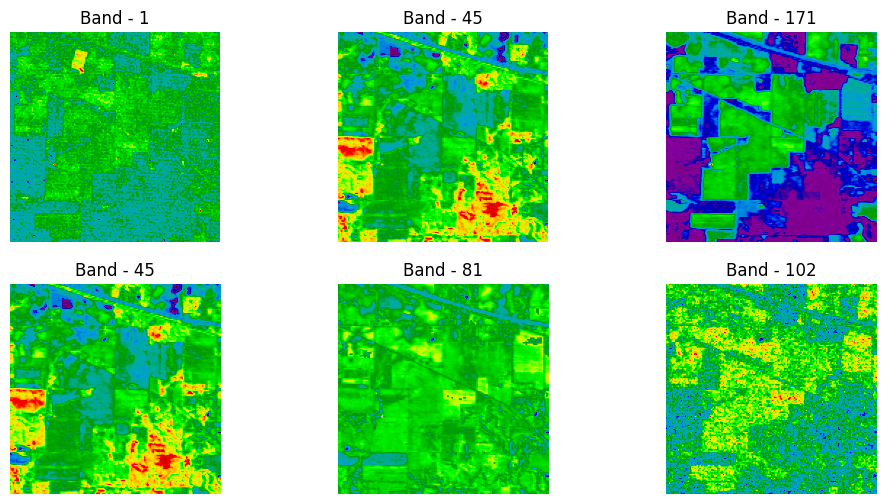

In [5]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

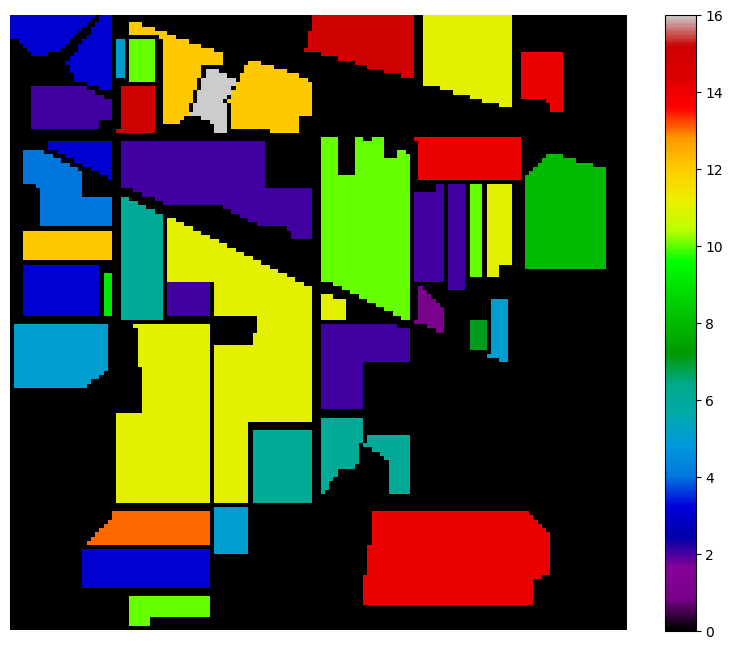

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [7]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)

df


band1  band2  band3  band4  band5  band6  band7  band8  band9  band10  \
0       3172   4142   4506   4279   4782   5048   5213   5106   5053    4750   
1       2580   4266   4502   4426   4853   5249   5352   5353   5347    5065   
2       3687   4266   4421   4498   5019   5293   5438   5427   5383    5132   
3       2749   4258   4603   4493   4958   5234   5417   5355   5349    5096   
4       2746   4018   4675   4417   4886   5117   5215   5096   5098    4834   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...     ...   
21020   2561   3987   4011   4023   4201   4377   4418   4248   4180    3838   
21021   2726   4104   4024   3880   4210   4377   4413   4174   4229    3900   
21022   3153   3864   4282   3889   4310   4372   4375   4208   4096    3878   
21023   3155   4104   4106   4027   4139   4318   4413   4174   4140    3933   
21024   3323   3860   4197   3952   4148   4279   4375   4225   3988    3866   

       ...  band192  band193  band194  band195  band196  band197  band198  \
0      ...     1094     1090     1112     1090     1062     1069     1057   
1      ...     1108     1104     1117     1091     1079     1085     1064   
2      ...     1111     1114     1114     1100     1065     1092     1061   
3      ...     1122     1108     1109     1109     1071     1088     1060   
4      ...     1110     1107     1112     1094     1072     1087     1052   
...    ...      ...      ...      ...      ...      ...      ...      ...   
21020  ...     1013     1012     1018     1015     1011     1001     1000   
21021  ...     1012     1014     1012     1024      998     1010     1006   
21022  ...     1016     1015     1016     1021     1008     1019     1003   
21023  ...     1005     1011     1008     1012     1014     1007     1011   
21024  ...     1018     1014     1007     1015     1002     1010     1007   

       band199  band200  class  
0         1020     1020      3  
1         1029     1020      3  
2         1030     1016      3  
3         1030     1006      3  
4         1034     1019      3  
...        ...      ...    ...  
21020     1009     1008      0  
21021     1000     1000      0  
21022     1008     1000      0  
21023     1005     1003      0  
21024     1004     1000      0  

[21025 rows x 201 columns]

In [8]:
df.shape

(21025, 201)

# EDA 

Perform exploratory data analysis on the tabular data

              band1         band2         band3         band4         band5  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    2957.363472   4091.321237   4277.502259   4169.956671   4516.678668   
std      354.918708    230.390005    257.827640    280.761254    346.035984   
min     2560.000000   2709.000000   3649.000000   2810.000000   3840.000000   
25%     2602.000000   3889.000000   4066.000000   3954.000000   4214.000000   
50%     2780.000000   4106.000000   4237.000000   4126.000000   4478.000000   
75%     3179.000000   4247.000000   4479.000000   4350.000000   4772.000000   
max     4536.000000   5744.000000   6361.000000   6362.000000   7153.000000   

              band6         band7         band8         band9        band10  \
count  21025.000000  21025.000000  21025.000000  21025.000000  21025.000000   
mean    4790.595149   4848.317574   4714.732509   4668.904828   4439.065541   
std      414.382138    469.247667    491.728349    

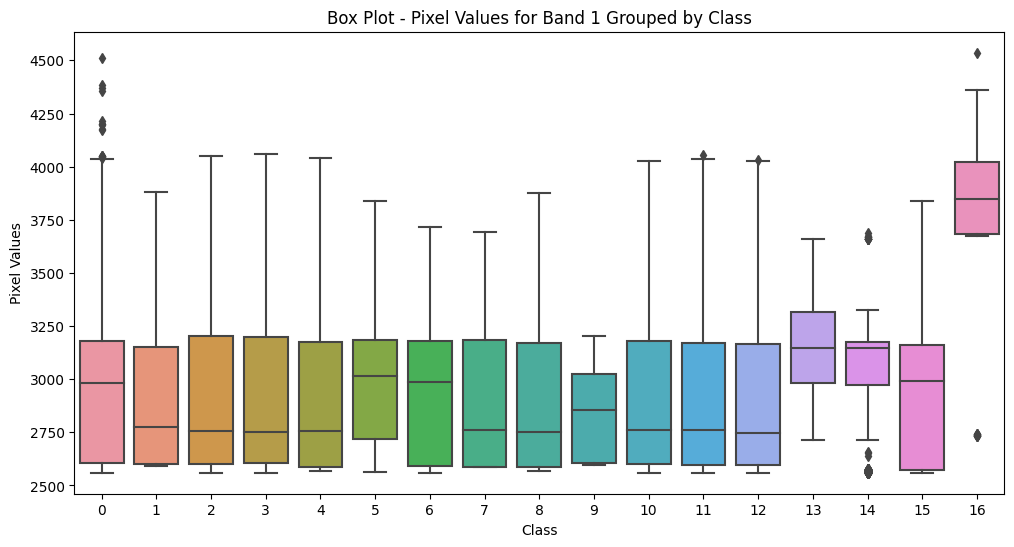

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extraction of pixels 
def extract_pixels(X, y):
    q = X.reshape(-1, X.shape[2])
    df = pd.DataFrame(data=q)
    df = pd.concat([df, pd.DataFrame(data=y.ravel())], axis=1)
    df.columns = [f'band{i}' for i in range(1, 1 + X.shape[2])] + ['class']
    df.to_csv('Dataset.csv', index=False)
    return df

df = extract_pixels(X, y)

# Descriptive Statistics
descriptive_stats = df.describe()
print(descriptive_stats)


# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band1')
plt.title('Box Plot - Pixel Values for Band 1 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()


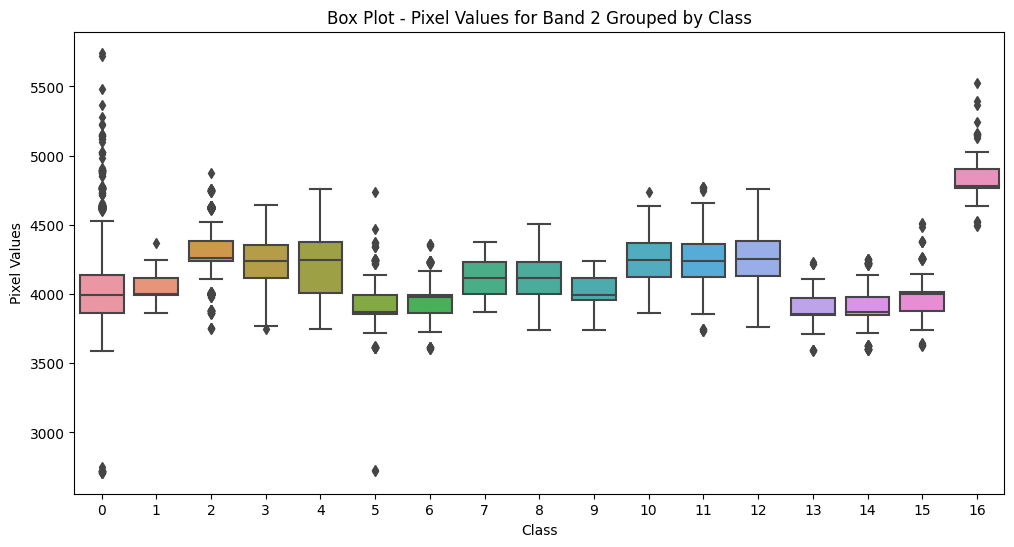

In [10]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band2')
plt.title('Box Plot - Pixel Values for Band 2 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

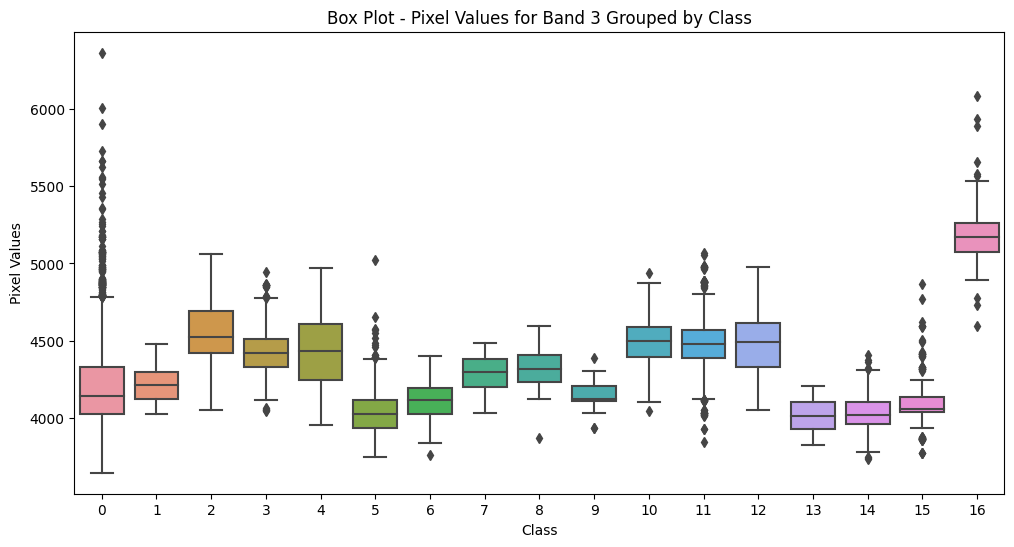

In [11]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band3')
plt.title('Box Plot - Pixel Values for Band 3 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

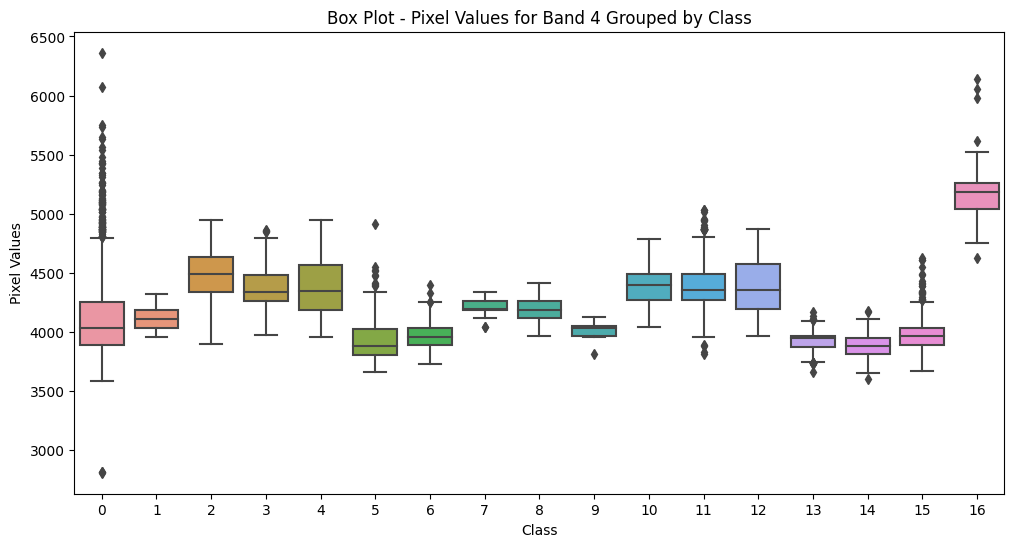

In [12]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band4')
plt.title('Box Plot - Pixel Values for Band 4 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

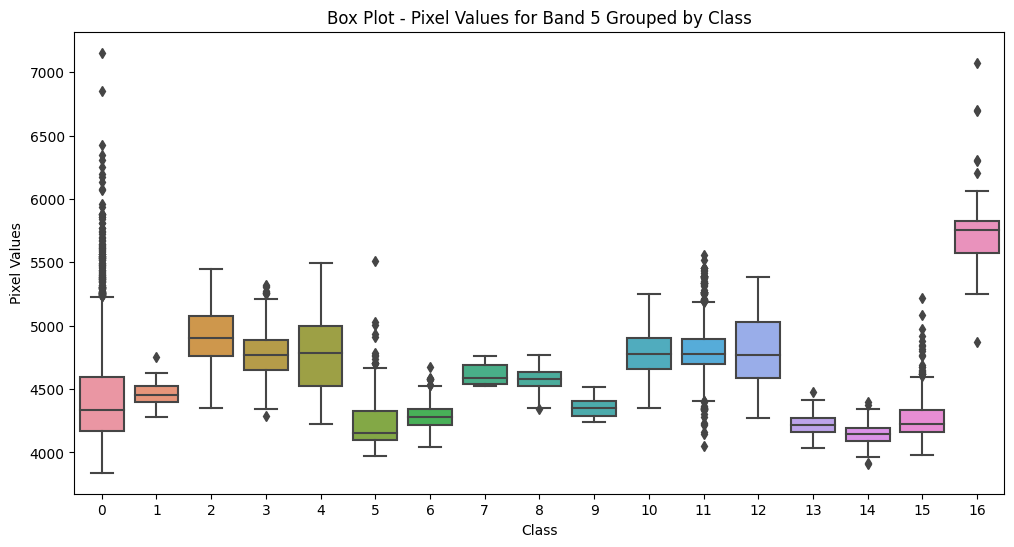

In [13]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band5')
plt.title('Box Plot - Pixel Values for Band 5 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

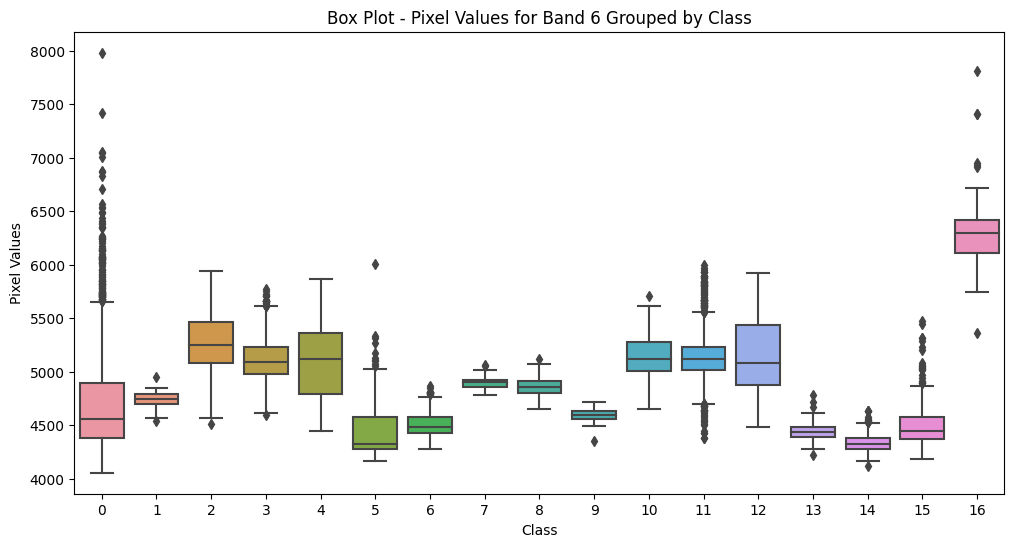

In [14]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band6')
plt.title('Box Plot - Pixel Values for Band 6 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

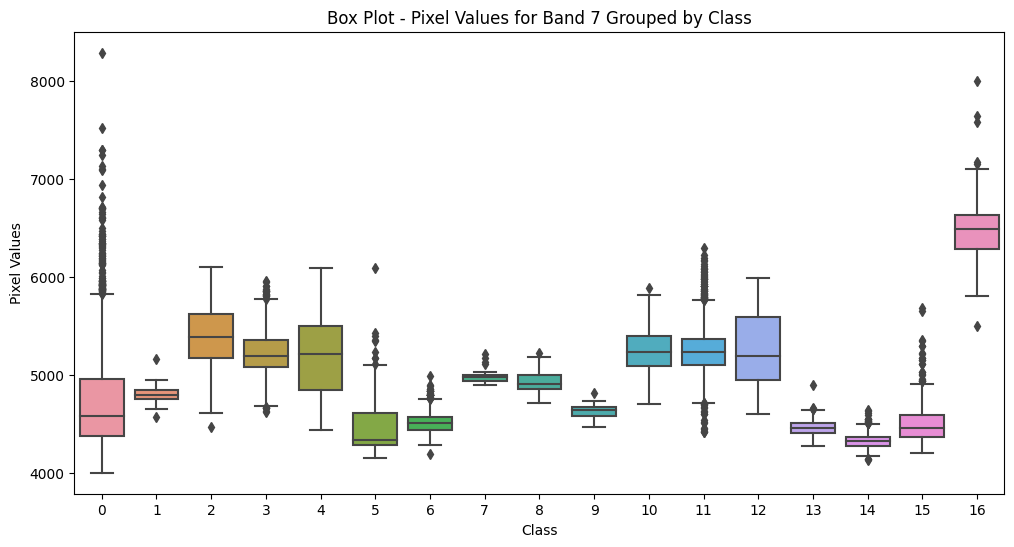

In [15]:
# Box plot for band grouped by object class column
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band7')
plt.title('Box Plot - Pixel Values for Band 7 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

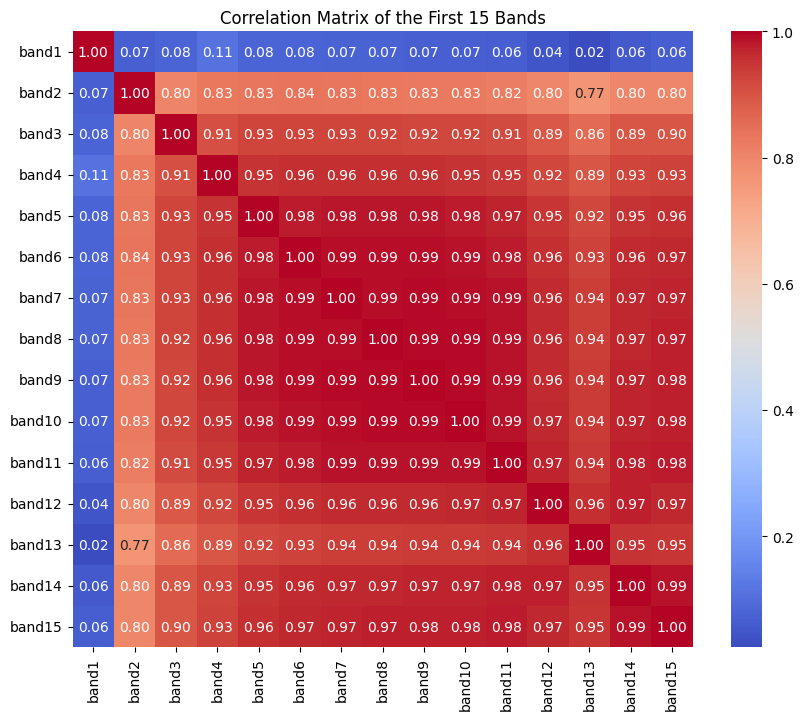

In [16]:
# Extracting pixel values of the first 15 bands for correlation analysis
first_15_bands_df = df.iloc[:, :15]

# Calculating the correlation matrix for the first 10 bands
correlation_matrix_first_15 = first_15_bands_df.corr()

# Visualizing the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_first_15, cmap='coolwarm', annot=True, fmt=".2f", xticklabels=first_15_bands_df.columns, yticklabels=first_15_bands_df.columns)
plt.title('Correlation Matrix of the First 15 Bands')
plt.show()

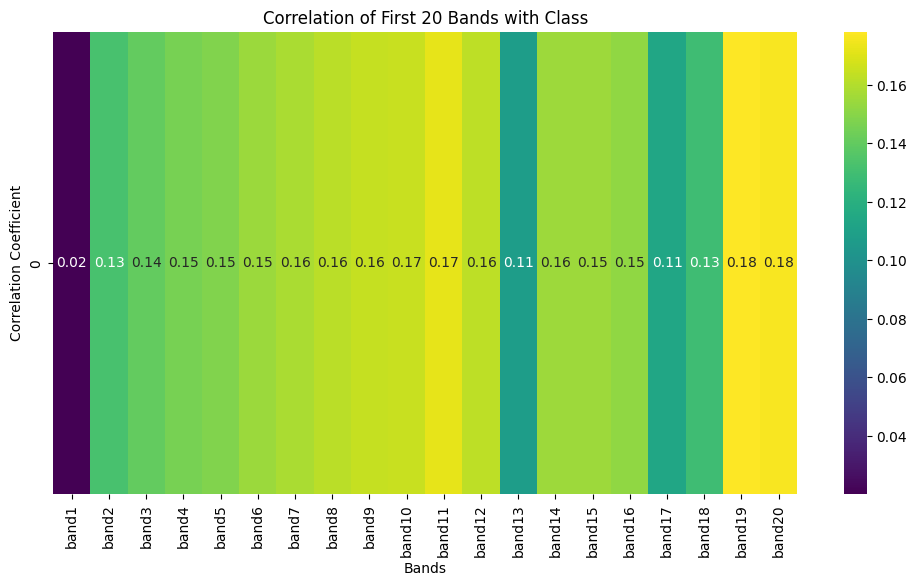

In [17]:
# Extracting pixel values and the 'class' column for the first n bands
n = 20
first_n_bands_and_class_df = df.iloc[:, :n]

# Calculating the correlation matrix with class
correlation_matrix_with_class_first_n = first_n_bands_and_class_df.corrwith(df.iloc[:, -1])

# Visualizing the correlation with class as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_with_class_first_n.to_frame().T, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Correlation of First 20 Bands with Class')
plt.xlabel('Bands')
plt.ylabel('Correlation Coefficient')
plt.show()

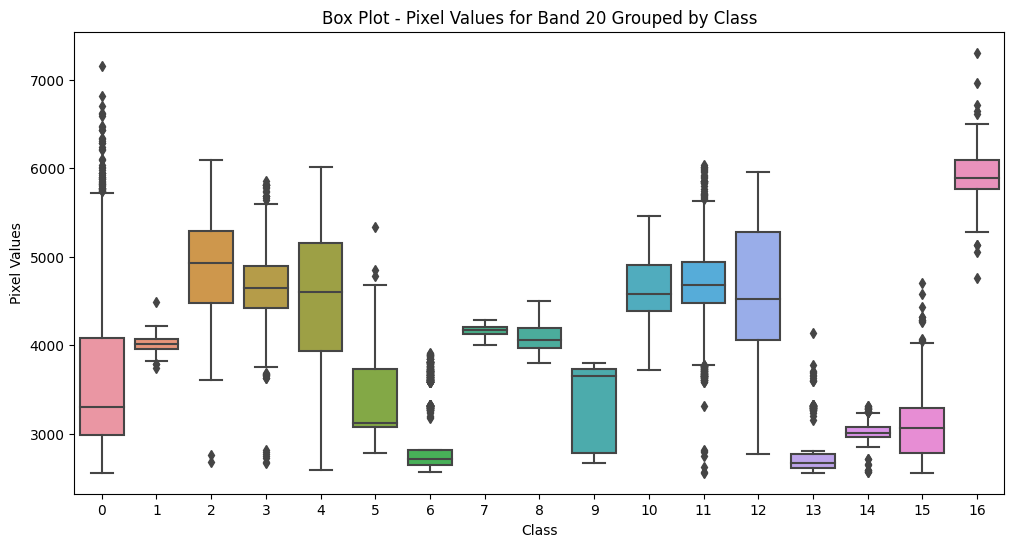

In [18]:
# Box plot for band grouped by object class
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band20')
plt.title('Box Plot - Pixel Values for Band 20 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

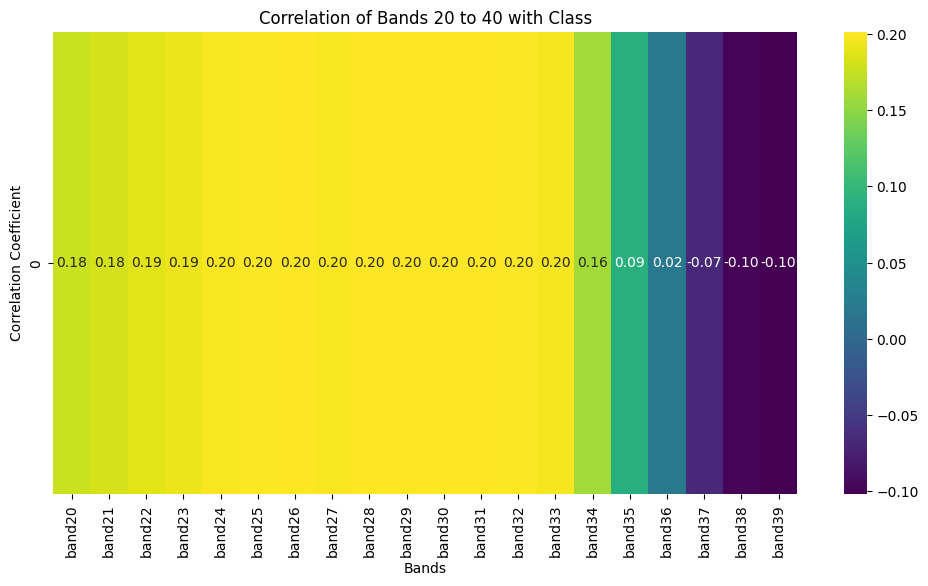

In [19]:
# Extracting pixel values and the 'class' column for bands 20 to 40
bands_20_to_40_and_class_df = df.iloc[:, 19:39]  # Adjust indices as needed

# Calculating the correlation matrix with class column
correlation_matrix_with_class_20_to_40 = bands_20_to_40_and_class_df.corrwith(df.iloc[:, -1])

# Visualizing the correlation with class column as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_with_class_20_to_40.to_frame().T, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Correlation of Bands 20 to 40 with Class')
plt.xlabel('Bands')
plt.ylabel('Correlation Coefficient')
plt.show()

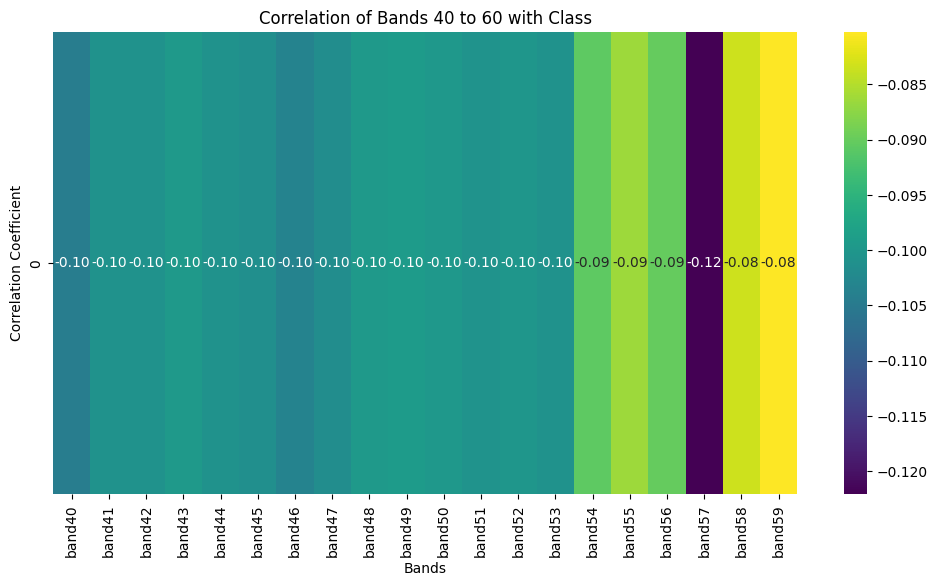

In [20]:
# Extracting pixel values and the 'class' column for bands 40 to 60
bands_40_to_60_and_class_df = df.iloc[:, 39:59]  # Adjust indices as needed

# Calculating the correlation matrix with class column
correlation_matrix_with_class_40_to_60 = bands_40_to_60_and_class_df.corrwith(df.iloc[:, -1])

# Visualizing the correlation with class column as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix_with_class_40_to_60.to_frame().T, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Correlation of Bands 40 to 60 with Class')
plt.xlabel('Bands')
plt.ylabel('Correlation Coefficient')
plt.show()

Text(270.72222222222223, 0.5, 'Correlation Coefficient')

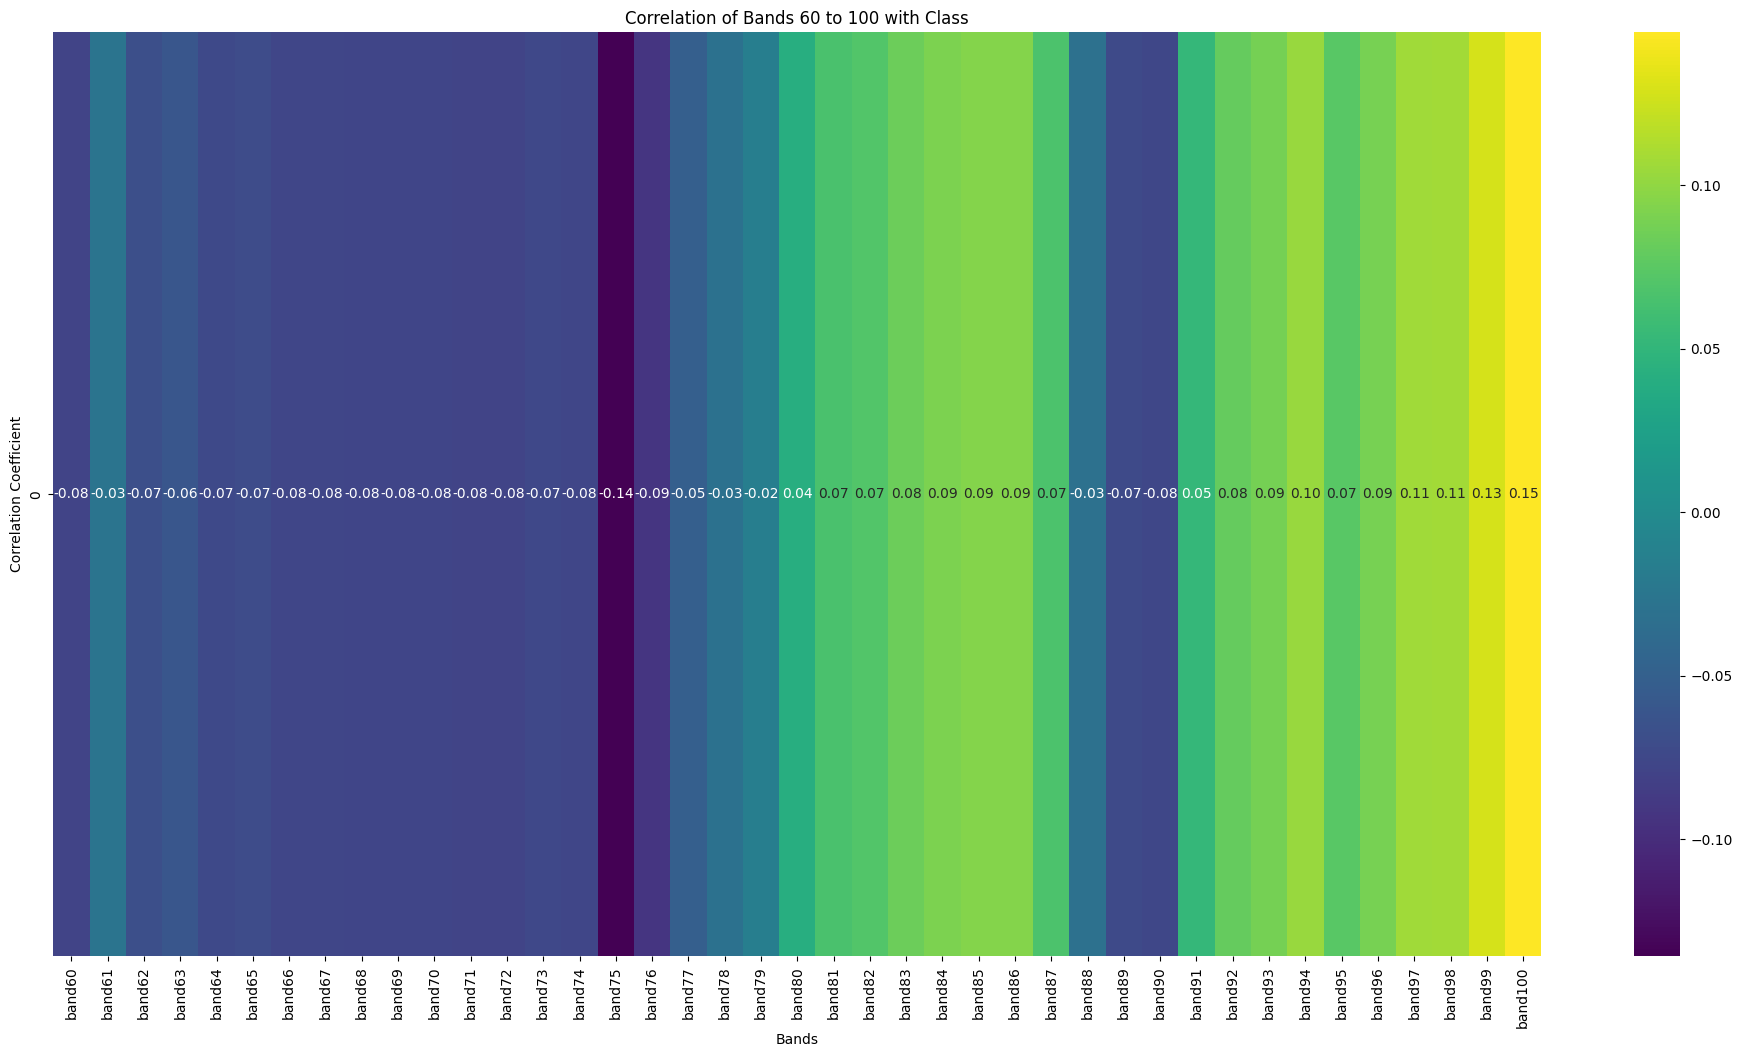

In [21]:
# Extracting pixel values and the 'class' column for bands 60 to 100
bands_60_to_100_and_class_df = df.iloc[:, 59:100]  # Adjust indices as needed

# Calculating the correlation matrix with class column
correlation_matrix_with_class_60_to_100 = bands_60_to_100_and_class_df.corrwith(df.iloc[:, -1])

# Visualizing the correlation with class as a heatmap
plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix_with_class_60_to_100.to_frame().T, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Correlation of Bands 60 to 100 with Class')
plt.xlabel('Bands')
plt.ylabel('Correlation Coefficient')

Text(270.72222222222223, 0.5, 'Correlation Coefficient')

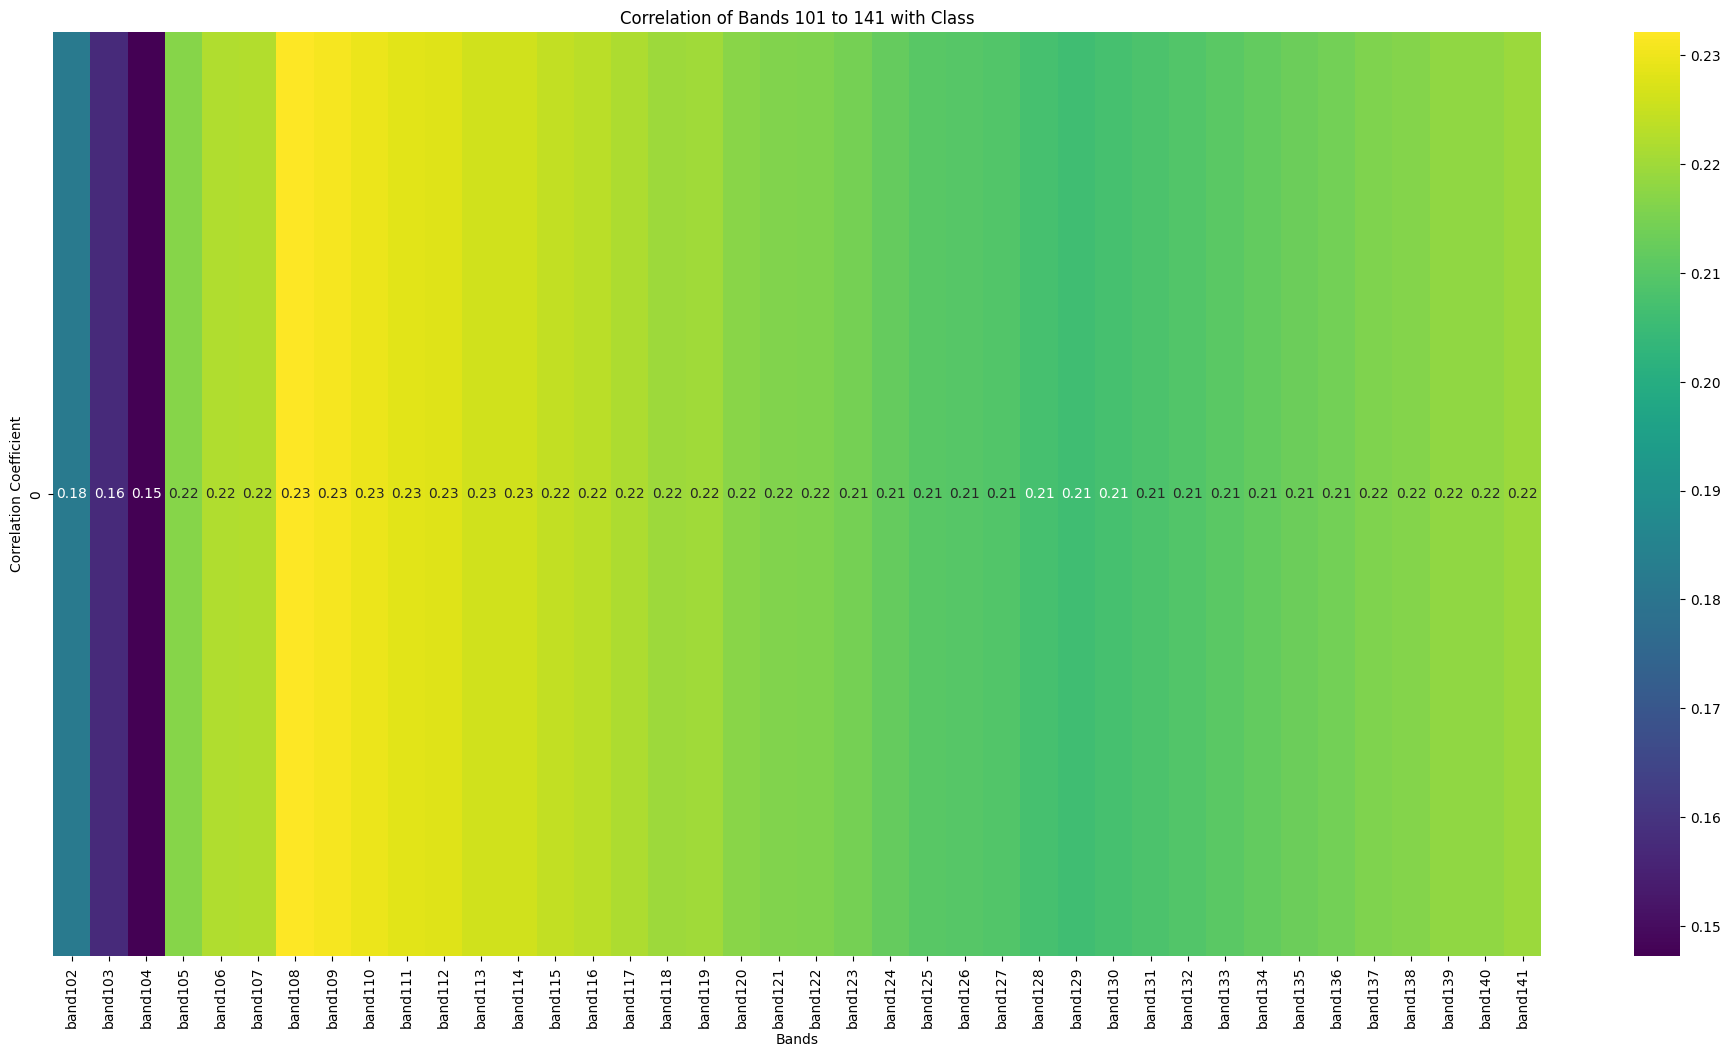

In [22]:
# Extracting pixel values and the 'class' column for bands 101 to 141
bands_101_to_141_and_class_df = df.iloc[:, 101:141]  # Adjust indices as needed

# Calculating the correlation matrix with class
correlation_matrix_with_class_101_to_141 = bands_101_to_141_and_class_df.corrwith(df.iloc[:, -1])

# Visualizing the correlation with class as a heatmap
plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix_with_class_101_to_141.to_frame().T, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Correlation of Bands 101 to 141 with Class')
plt.xlabel('Bands')
plt.ylabel('Correlation Coefficient')

In [23]:
# Extracting pixel values and the 'class' column for all bands
all_bands_and_class_df = df.iloc[:, :-1]

# Calculating the correlation coefficients with class
correlation_with_class = all_bands_and_class_df.corrwith(df.iloc[:, -1])

# Filtering bands with correlation coefficient >= 0.238
selected_bands = correlation_with_class[abs(correlation_with_class) >= 0.238]

# Display the selected bands and their correlation coefficients
print("Selected Bands with Correlation Coefficient >= 0.238:")
print(selected_bands)
selected_bands.shape


Selected Bands with Correlation Coefficient >= 0.238:
band147    0.245247
band148    0.245009
band149    0.242812
band150    0.242855
band151    0.238947
band153    0.238003
band155    0.239565
band184    0.238006
band185    0.241086
band188    0.238426
band190    0.239321
band191    0.238504
band192    0.239755
band193    0.241024
band194    0.242920
band195    0.238310
band196    0.240277
dtype: float64


(17,)

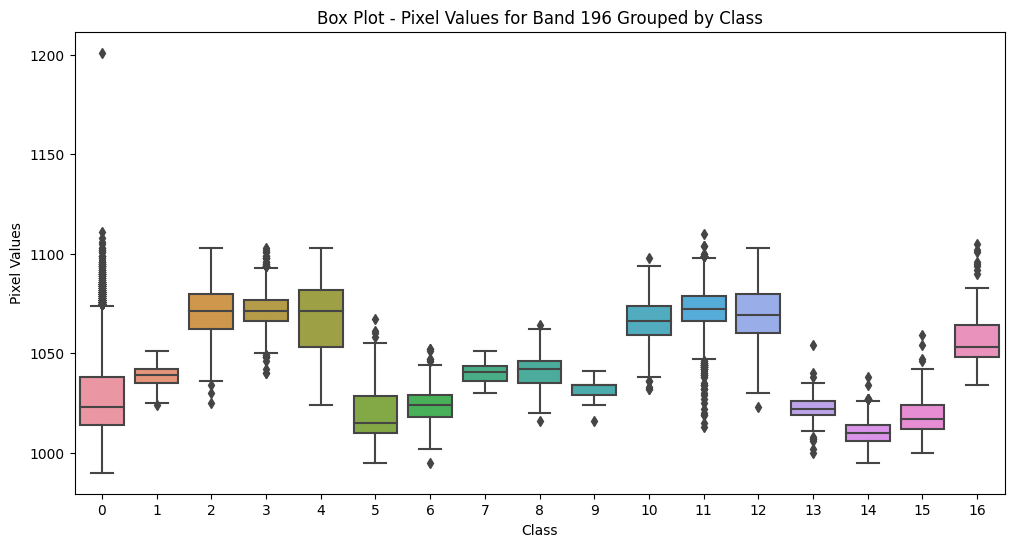

In [24]:
# Box plot for band grouped by object class
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band196')
plt.title('Box Plot - Pixel Values for Band 196 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

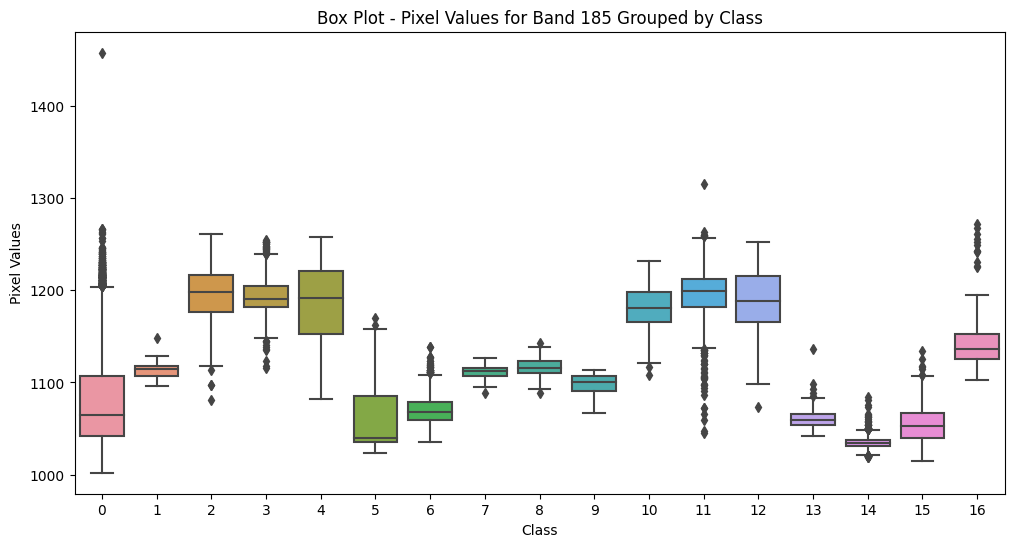

In [25]:
# Box plot for band grouped by object class
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band185')
plt.title('Box Plot - Pixel Values for Band 185 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

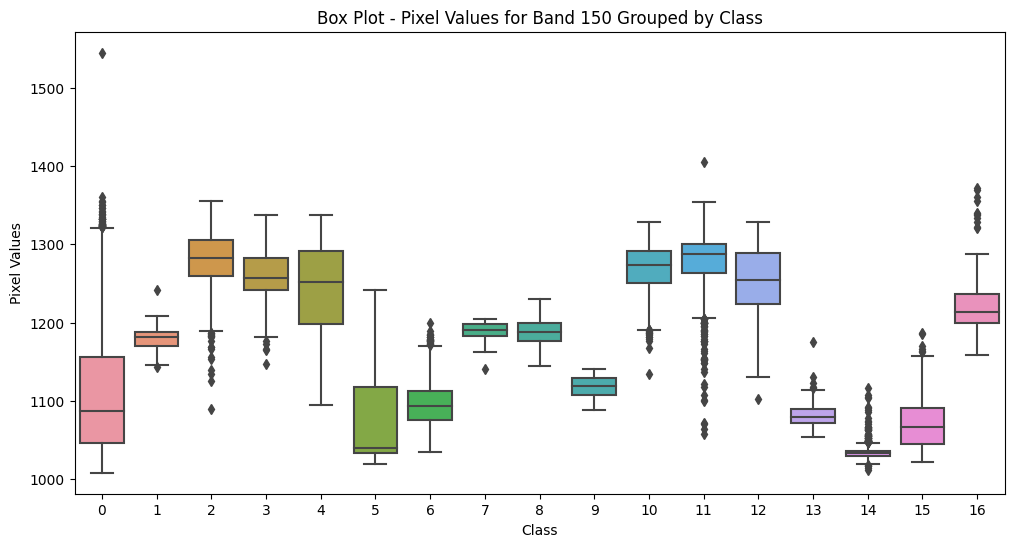

In [26]:
# Box plot for band grouped by object class
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='class', y='band150')
plt.title('Box Plot - Pixel Values for Band 150 Grouped by Class')
plt.xlabel('Class')
plt.ylabel('Pixel Values')
plt.show()

Selected Bands with Correlation Coefficient > 0.10:
band2      0.131936
band3      0.140344
band4      0.145999
band5      0.148001
band6      0.154334
             ...   
band196    0.240277
band197    0.237760
band198    0.235095
band199    0.212090
band200    0.144216
Length: 151, dtype: float64


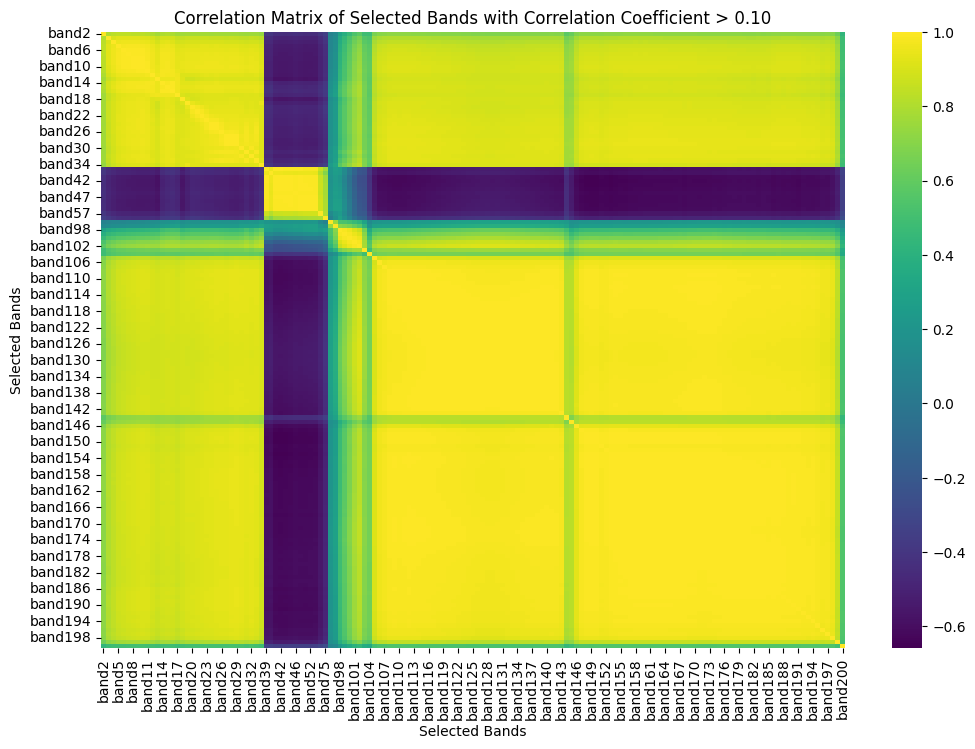

In [27]:
# Extracting pixel values and the 'class' column for all bands
all_bands_and_class_df = df.iloc[:, :-1]

# Calculating the correlation coefficients with class
correlation_with_class = all_bands_and_class_df.corrwith(df.iloc[:, -1])

# Filtering bands with correlation coefficient > 0.10
selected_bands = correlation_with_class[abs(correlation_with_class) > 0.10]

# Display the selected bands and their correlation coefficients
print("Selected Bands with Correlation Coefficient > 0.10:")
print(selected_bands)

# Extracting pixel values and the 'class' column for selected bands
selected_bands_df = all_bands_and_class_df[selected_bands.index]

# Calculate the correlation matrix for the selected bands
correlation_matrix_selected_bands = selected_bands_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected_bands, cmap='viridis', annot=False, fmt=".2f", cbar=True)
plt.title('Correlation Matrix of Selected Bands with Correlation Coefficient > 0.10')
plt.xlabel('Selected Bands')
plt.ylabel('Selected Bands')
plt.show()

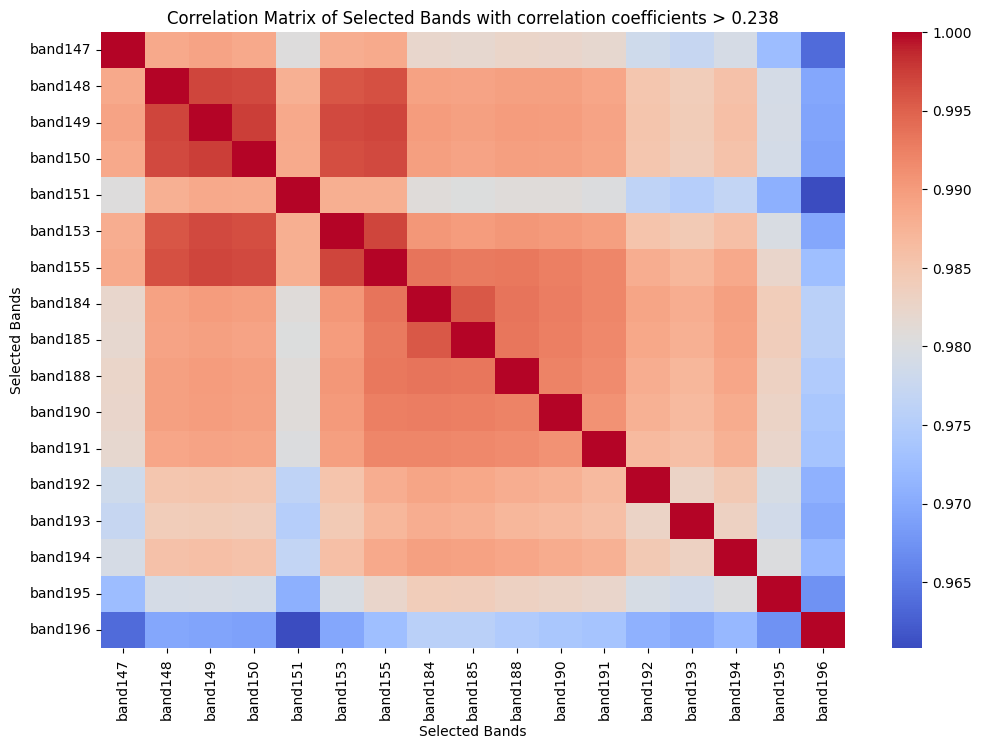

In [28]:
# Extracting pixel values and the 'class' column for all bands
all_bands_and_class_df = df.iloc[:, :-1]

# Calculating the correlation coefficients with class
correlation_with_class = all_bands_and_class_df.corrwith(df.iloc[:, -1])

# Filtering bands with correlation coefficient > 0.2380
selected_bands = correlation_with_class[abs(correlation_with_class) > 0.2380]

# Extracting pixel values and the 'class' column for selected bands
selected_bands_df = all_bands_and_class_df[selected_bands.index]

# Calculate the correlation matrix for the selected bands
correlation_matrix_selected_bands = selected_bands_df.corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_selected_bands, cmap='coolwarm', annot=False, fmt=".2f", cbar=True)
plt.title('Correlation Matrix of Selected Bands with correlation coefficients > 0.238')
plt.xlabel('Selected Bands')
plt.ylabel('Selected Bands')
plt.show()

## Principal Component Analysis(PCA)


STEPS

1. Estimate the basis of Principal components

2. Plot the cumulative explained variance associated with Principal components VS Number of components.

3. Select acordingly the no.of components for PCA projection

4. Reconstruct the images associated to the different bands using the selected principal components

In [29]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


Explained Variance Ratio: [0.6861814  0.19194106 0.0256119  0.01686552 0.01049086 0.00840367
 0.00470794 0.00392647 0.00372137 0.00346936 0.00284681 0.00245584
 0.0021413  0.00197483 0.00185906 0.00180116 0.00174135 0.00157971
 0.00154045 0.00150035]


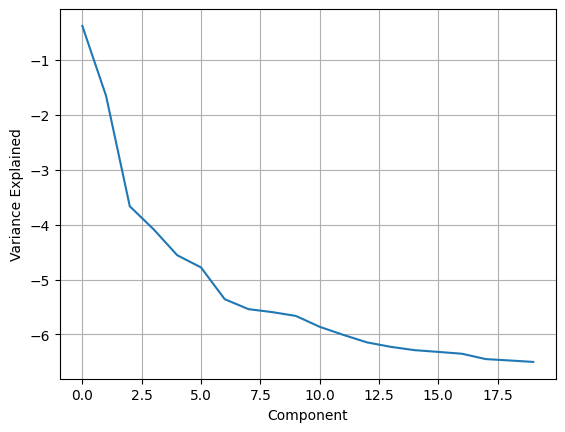

Cumulative Explained Variance:
PC1: 0.6861814043981013
PC2: 0.8781224595972157
PC3: 0.9037343598379057
PC4: 0.9205998778897349
PC5: 0.9310907334097205
PC6: 0.9394944070262952
PC7: 0.9442023472866338
PC8: 0.948128817739285
PC9: 0.9518501886576077
PC10: 0.9553195451272432
PC11: 0.9581663514644235
PC12: 0.9606221886812469
PC13: 0.9627634883246456
PC14: 0.9647383223695143
PC15: 0.9665973825268483
PC16: 0.9683985399613753
PC17: 0.970139887714814
PC18: 0.9717195981938077
PC19: 0.9732600487613512
PC20: 0.9747603968618552


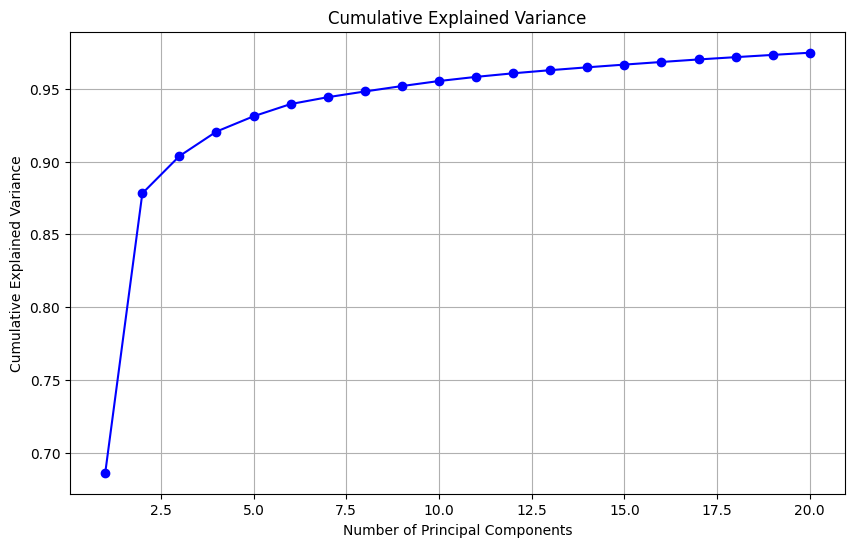

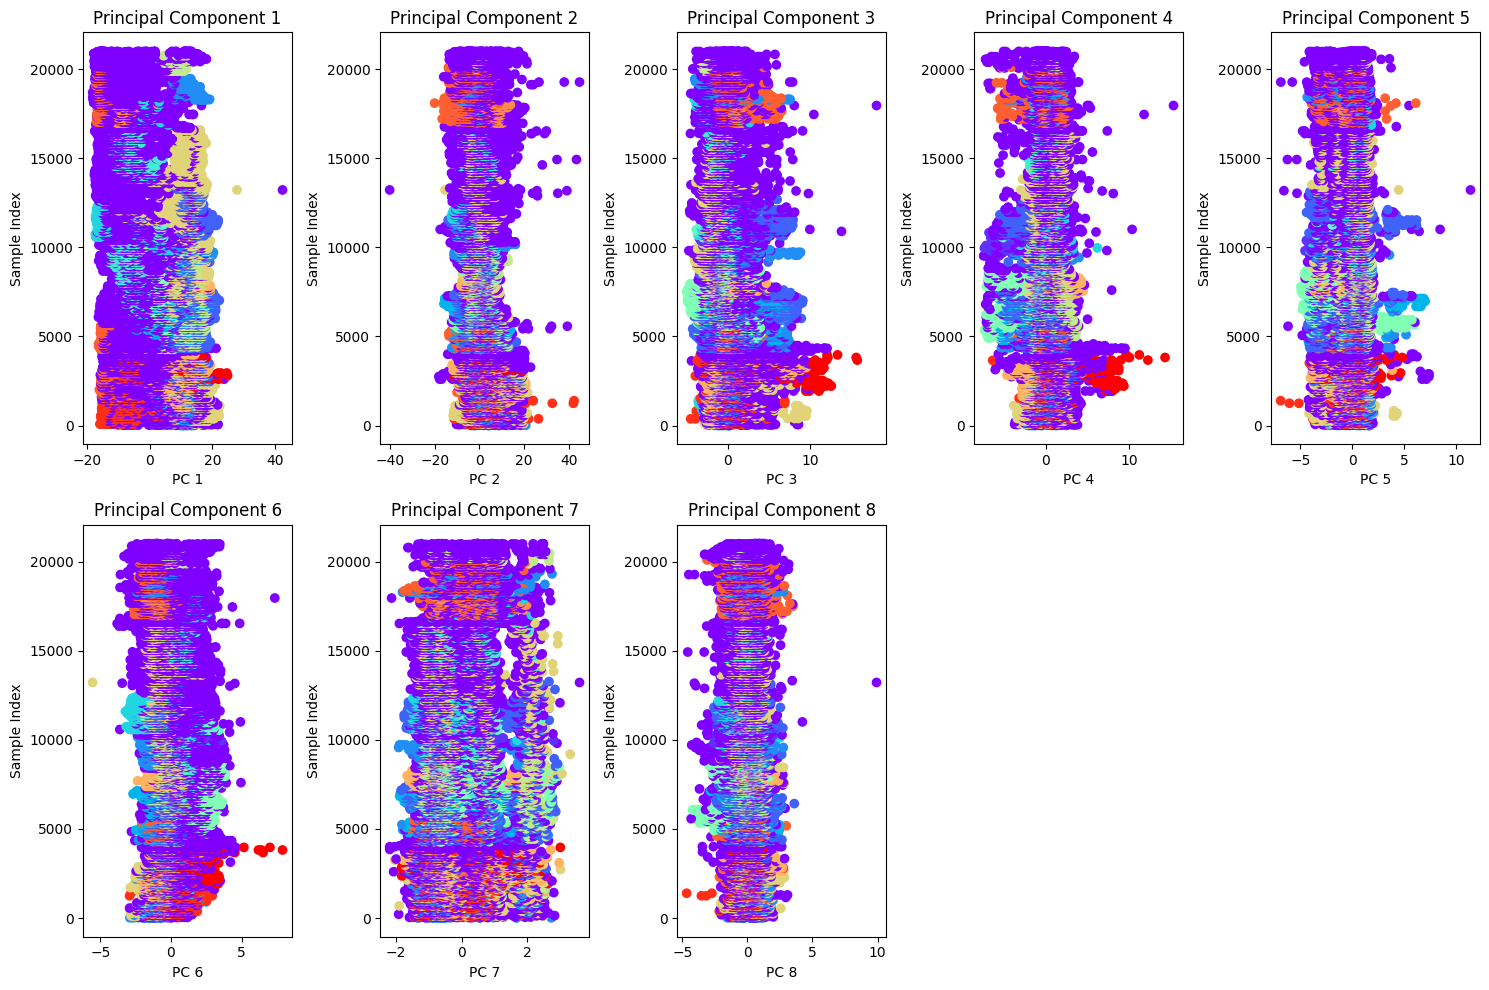

In [30]:

# y represent the label or specie of the pine tree(target)

def f_PCA(X, n_components=200):
    # Reshape the data to 2D array (pixel values as features, using bands as samples)
    X_reshaped = X.reshape((-1, X.shape[2]))

    # Standardize the data
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_reshaped)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_std)

    # Print the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)
    
    # Visualize the explained variance ratio
    plt.plot(np.log(explained_variance_ratio))
    plt.grid()
    plt.xlabel('Component')
    plt.ylabel('Variance Explained')
    plt.show()

    # Calculate cumulative explained variance
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Print cumulative explained variance
    print("Cumulative Explained Variance:")
    for i in range(n_components):
        print(f"PC{i + 1}: {cumulative_variance_ratio[i]}")

    # Visualize the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    return X_pca, pca

# Perform the PCA on 20 components, print the explained variance ratio, and visualize it 
X_pca, pca = f_PCA(X, n_components=20)

# Reconstruct the data using the inverse_transform method
X_reconstructed = pca.inverse_transform(X_pca)

# Visualize n pcs
# flatten the X_pca matrix
n_components = 8
plt.figure(figsize=(15, 10))
for i in range(n_components):
    plt.subplot(2, 5, i + 1)
    plt.scatter(X_pca[:, i], range(len(X_pca)), c=y.flatten(), cmap='rainbow')
    plt.title(f'Principal Component {i + 1}')
    plt.xlabel(f'PC {i + 1}')
    plt.ylabel('Sample Index')

plt.tight_layout()
plt.show()


In [31]:
X_pca.shape
#X_pca is the result of applying PCA
X_pca_five_components = X_pca[:, :8]
X_pca_five_components

array([[ 10.57398474,   4.21271342,   0.1883676 , ...,  -1.26959663,
          0.55729182,   0.67142596],
       [ 13.15770743,  -1.95441227,   0.15436688, ...,  -0.78979902,
         -1.34484218,   0.70547294],
       [ 14.07035027,  -3.84390553,   0.10099212, ...,  -1.24870316,
          1.6748807 ,   0.16843457],
       ...,
       [-15.3038839 ,  -3.54400039,   0.64108557, ...,  -0.29543238,
          0.4584667 ,   0.89081529],
       [-15.37571036,   1.1407    ,   1.32109098, ...,  -1.06828556,
          0.48026173,   0.62532834],
       [-15.33317397,   0.18197926,   1.24221309, ...,  -0.93560287,
          0.92534388,   0.54174132]])

/tmp/ipykernel_383/1495273976.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, i], y.flatten(), cmap='rainbow')


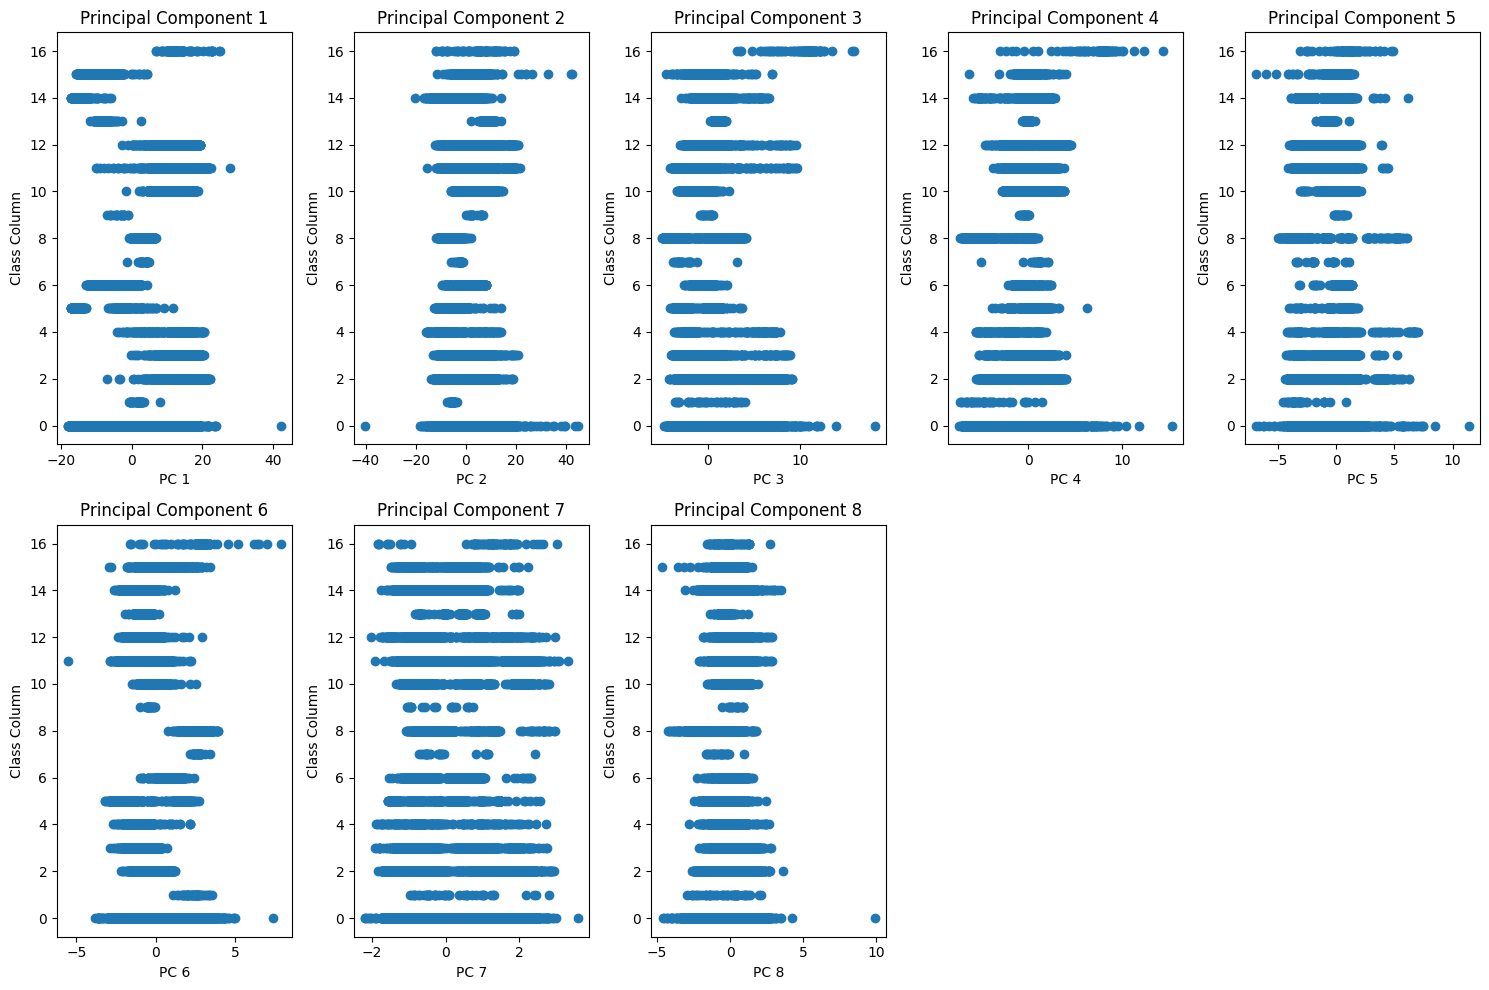

In [39]:
# Visualize individual principal components with respect to the target column
n_components = 8
plt.figure(figsize=(15, 10))
for i in range(n_components):
    plt.subplot(2, 5, i + 1)
    plt.scatter(X_pca[:, i], y.flatten(), cmap='rainbow')
    plt.title(f'Principal Component {i + 1}')
    plt.xlabel(f'PC {i + 1}')
    plt.ylabel('Class Column')

plt.tight_layout()
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler

# Reshape the data to 2D array (pixel values as features, using bands as samples)
X_reshaped = X.reshape((-1, X.shape[2]))

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X_reshaped)


In [42]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize LDA
lda = LinearDiscriminantAnalysis(n_components=min(X.shape[0], X.shape[1], len(np.unique(y)) - 1))

# Fit and transform the data
X_lda = lda.fit_transform(X_std, y.flatten())


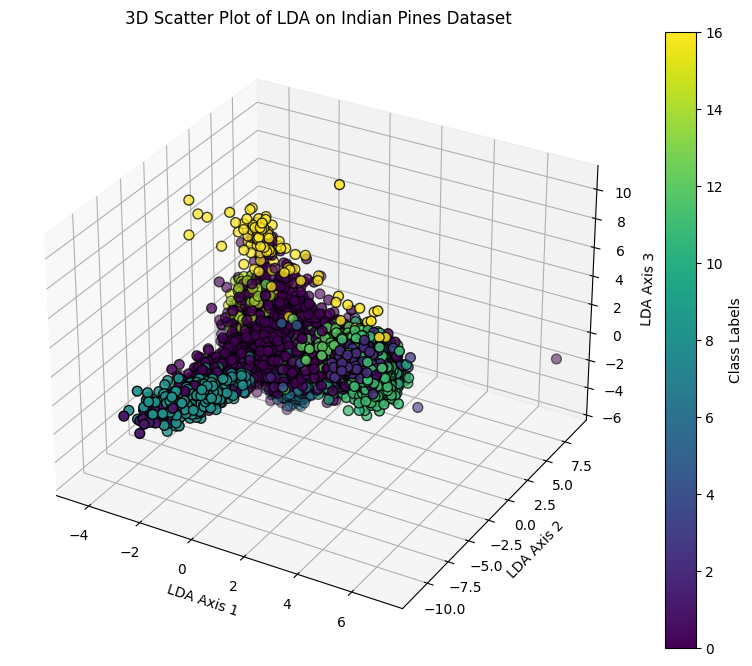

In [46]:

# Create a 3D scatter plot using the first three discriminant axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_lda[:, 0], X_lda[:, 1], X_lda[:, 2], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)

# Add labels and title
ax.set_xlabel('LDA Axis 1')
ax.set_ylabel('LDA Axis 2')
ax.set_zlabel('LDA Axis 3')
ax.set_title('3D Scatter Plot of LDA on Indian Pines Dataset')

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')

plt.show()


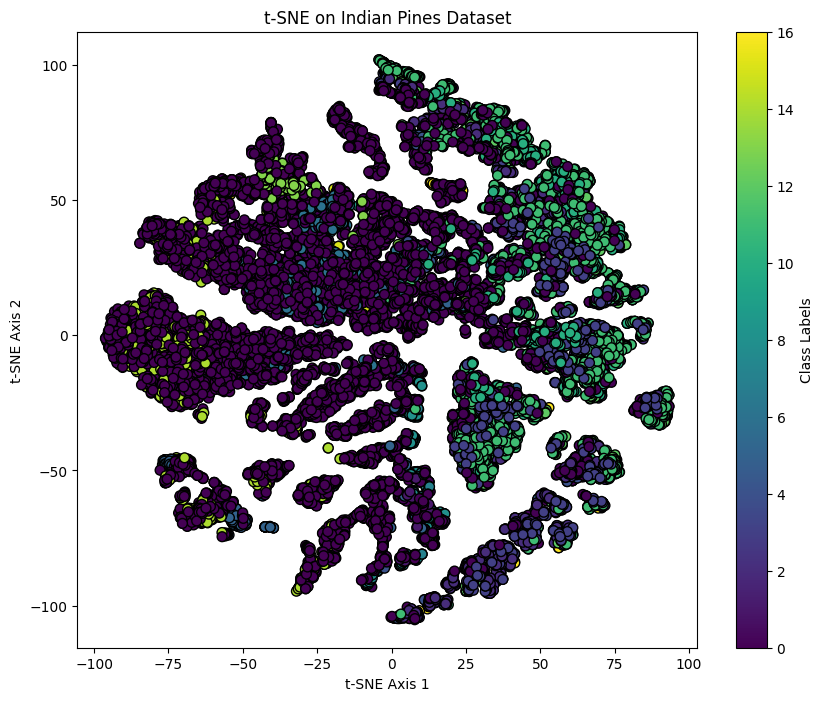

In [79]:
from sklearn.manifold import TSNE
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_std)

# Visualize the results in a 2D scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.flatten(), cmap='viridis', edgecolor='k', s=50)
plt.title('t-SNE on Indian Pines Dataset')
plt.xlabel('t-SNE Axis 1')
plt.ylabel('t-SNE Axis 2')

# Add colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Class Labels')

plt.show()

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y.flatten(), test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Initialize SVM classifier with a linear kernel
# Use a recommended value for C (e.g., C=1.0)
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_std)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Accuracy: 78.96%

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84      3273
           1       0.93      0.88      0.90        16
           2       0.78      0.77      0.78       427
           3       0.72      0.63      0.67       220
           4       0.79      0.65      0.71        80
           5       0.87      0.62      0.73       117
           6       0.90      0.72      0.80       227
           7       0.88      0.64      0.74        11
           8       0.91      0.91      0.91       146
           9       1.00      0.40      0.57         5
          10       0.79      0.68      0.73       291
          11       0.75      0.77      0.76       729
          12       0.81      0.70      0.75       194
          13       0.89      0.93      0.91        55
          14       0.64      0.51      0.57       391
          15       0.72      0.12      0.21       106
          16       0.69      0.90      

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Initialize LDA to reduce the data to 2 components for visualization
lda = LDA(n_components=42)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# Initialize SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_lda)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report
print('\nClassification Report:\n', classification_report(y_test, y_pred))

# Plot decision regions in the reduced 2D space
plot_decision_regions(X_test_lda, y_test, clf=svm_classifier, legend=2)
plt.title('Decision Regions with Linear Kernel (LDA)')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.show()


In [57]:
# Polynomial Kernel
# Initialize SVM classifier
svm_poly = SVC(kernel='poly', degree=3, random_state=42)

# Train the SVM classifier
svm_poly.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred_poly = svm_poly.predict(X_test_std)

# Evaluate the performance
accuracy_poly = accuracy_score(y_test, y_pred_poly)
print(f'Accuracy with Polynomial kernel: {accuracy_poly * 100:.2f}%')

# Display classification report
print(f'\nClassification Report with Polynomial kernel:\n', classification_report(y_test, y_pred_poly, zero_division=1))


Accuracy with Polynomial kernel: 72.08%

Classification Report with Polynomial kernel:
               precision    recall  f1-score   support

           0       0.71      0.92      0.80      3273
           1       1.00      0.00      0.00        16
           2       0.78      0.62      0.69       427
           3       0.81      0.40      0.53       220
           4       0.80      0.30      0.44        80
           5       0.95      0.53      0.68       117
           6       1.00      0.00      0.00       227
           7       1.00      0.00      0.00        11
           8       0.77      0.84      0.80       146
           9       1.00      0.00      0.00         5
          10       0.76      0.69      0.72       291
          11       0.68      0.78      0.72       729
          12       0.76      0.28      0.41       194
          13       0.87      0.73      0.79        55
          14       0.69      0.31      0.42       391
          15       1.00      0.00      0.00    

In [56]:
# RBF Kernel
# Initialize SVM classifier
svm_rbf = SVC(kernel='rbf', random_state=42)

# Train the SVM classifier
svm_rbf.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred_rbf = svm_rbf.predict(X_test_std)

# Evaluate the performance
accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
print(f'Accuracy with RBF kernel: {accuracy_rbf * 100:.2f}%')

# Display classification report
print(f'\nClassification Report with RBF kernel:\n', classification_report(y_test, y_pred_rbf, zero_division=1))


Accuracy with RBF kernel: 73.89%

Classification Report with RBF kernel:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82      3273
           1       1.00      0.00      0.00        16
           2       0.67      0.66      0.66       427
           3       0.78      0.46      0.58       220
           4       0.71      0.15      0.25        80
           5       0.92      0.50      0.65       117
           6       0.91      0.65      0.76       227
           7       1.00      0.00      0.00        11
           8       0.77      0.97      0.86       146
           9       1.00      0.00      0.00         5
          10       0.69      0.65      0.67       291
          11       0.69      0.81      0.74       729
          12       0.80      0.31      0.45       194
          13       0.89      0.89      0.89        55
          14       0.61      0.20      0.30       391
          15       1.00      0.00      0.00       106
       

In [55]:
# Sigmoid Kernel
# Initialize SVM classifier
svm_sigmoid = SVC(kernel='sigmoid', random_state=42)

# Train the SVM classifier
svm_sigmoid.fit(X_train_std, y_train)

# Make predictions on the test set
y_pred_sigmoid = svm_sigmoid.predict(X_test_std)

# Evaluate the performance
accuracy_sigmoid = accuracy_score(y_test, y_pred_sigmoid)
print(f'Accuracy with Sigmoid kernel: {accuracy_sigmoid * 100:.2f}%')

# Display classification report
print(f'\nClassification Report with Sigmoid kernel:\n', classification_report(y_test, y_pred_sigmoid, zero_division=1))


Accuracy with Sigmoid kernel: 52.19%

Classification Report with Sigmoid kernel:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74      3273
           1       1.00      0.00      0.00        16
           2       0.30      0.36      0.33       427
           3       0.19      0.01      0.03       220
           4       1.00      0.00      0.00        80
           5       0.09      0.11      0.10       117
           6       0.00      0.00      0.00       227
           7       0.00      0.00      0.00        11
           8       0.11      0.06      0.08       146
           9       1.00      0.00      0.00         5
          10       0.00      0.00      0.00       291
          11       0.39      0.51      0.44       729
          12       0.06      0.12      0.08       194
          13       0.04      0.02      0.03        55
          14       0.36      0.17      0.24       391
          15       1.00      0.00      0.00       106

In [32]:
X_reconstructed

array([[ 0.57878482,  0.31989116,  0.63646546, ...,  0.95697097,
         0.91062941,  1.64491138],
       [-1.08227177,  0.8244089 ,  1.0483176 , ...,  1.22865589,
         1.18462223,  1.67922333],
       [ 2.02661781,  0.82723995,  1.12235081, ...,  1.2823075 ,
         1.14228763,  1.10929463],
       ...,
       [ 0.56608498, -0.39644485, -0.72928449, ..., -1.07297764,
        -0.85820442, -1.1934778 ],
       [ 0.58417591, -0.04360894, -0.58284492, ..., -1.02681889,
        -0.76727116, -0.81913291],
       [ 1.03631656, -0.70421333, -0.79058969, ..., -1.0518111 ,
        -0.8471292 , -1.22827605]])

##### Bands before PCA

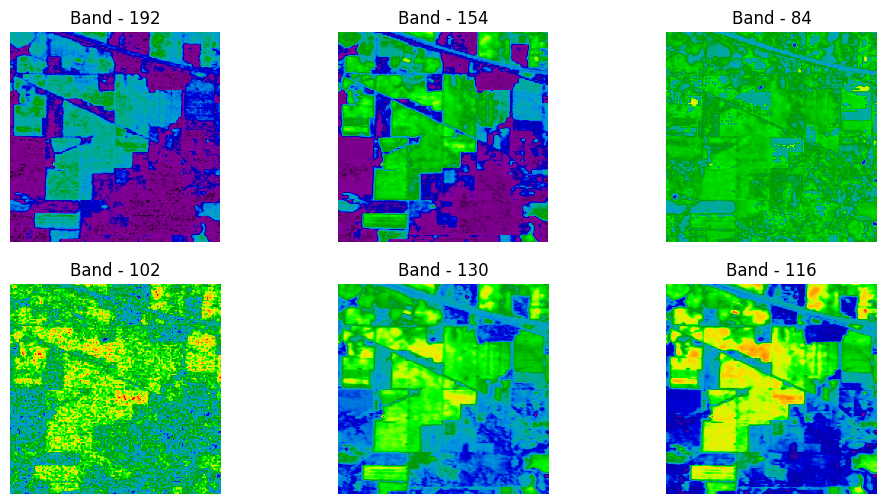

In [33]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

In [34]:
X.shape

(145, 145, 200)

In [35]:
X_reconstructed.shape


(21025, 200)

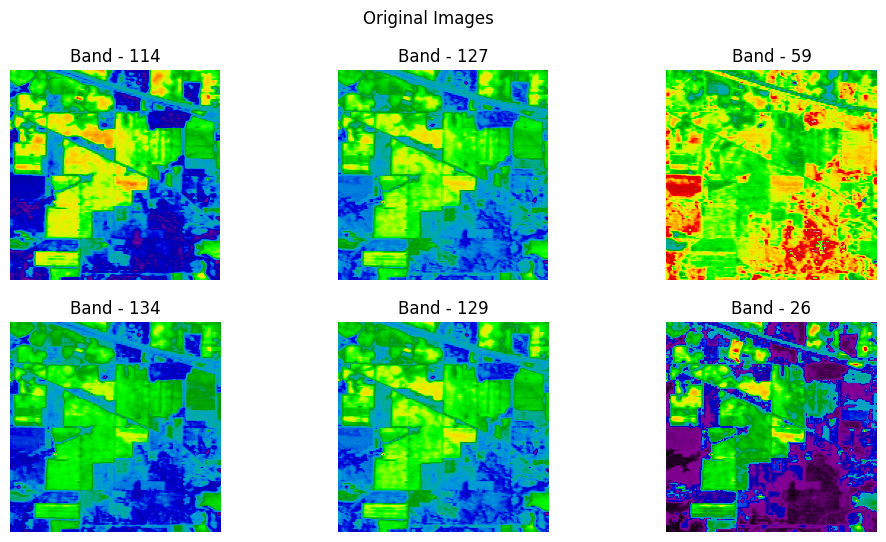

Explained Variance Ratio: [0.6861814  0.19194106 0.0256119  0.01686552 0.01049086 0.00840367
 0.00470794 0.00392647]


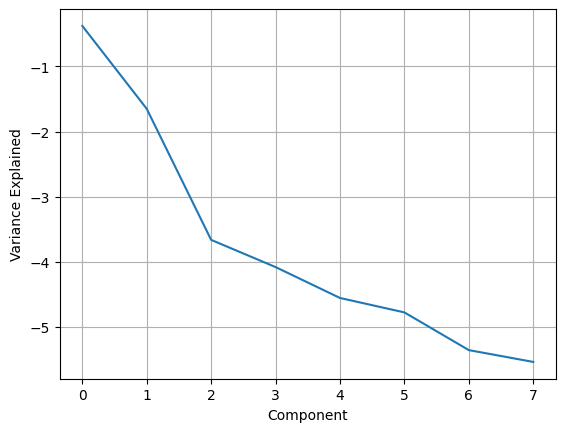

Cumulative Explained Variance:
PC1: 0.6861814043981022
PC2: 0.8781224595972164
PC3: 0.9037343598379066
PC4: 0.920599877889759
PC5: 0.9310907334101552
PC6: 0.9394944070308706
PC7: 0.9442023475518171
PC8: 0.94812881466578


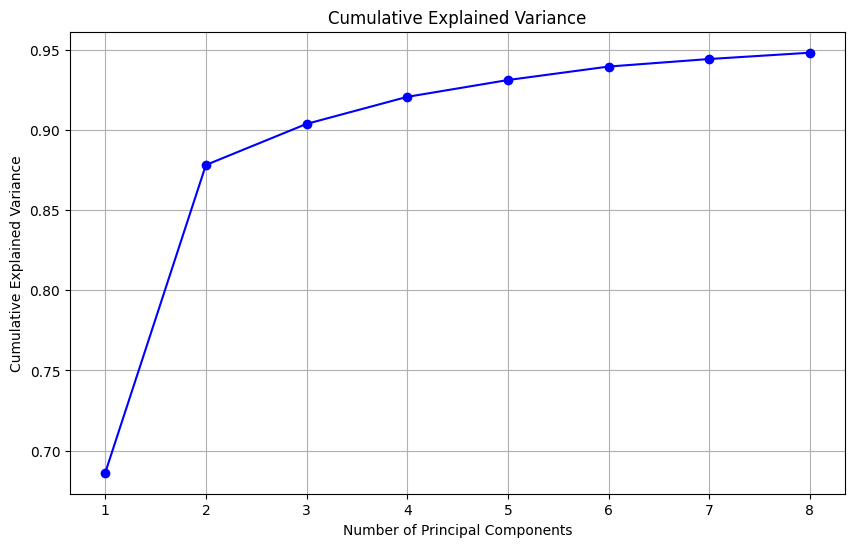

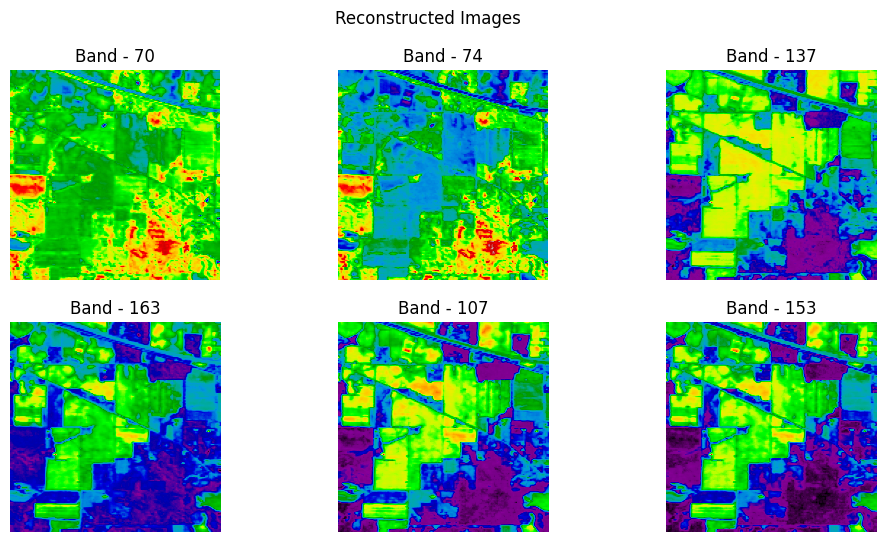

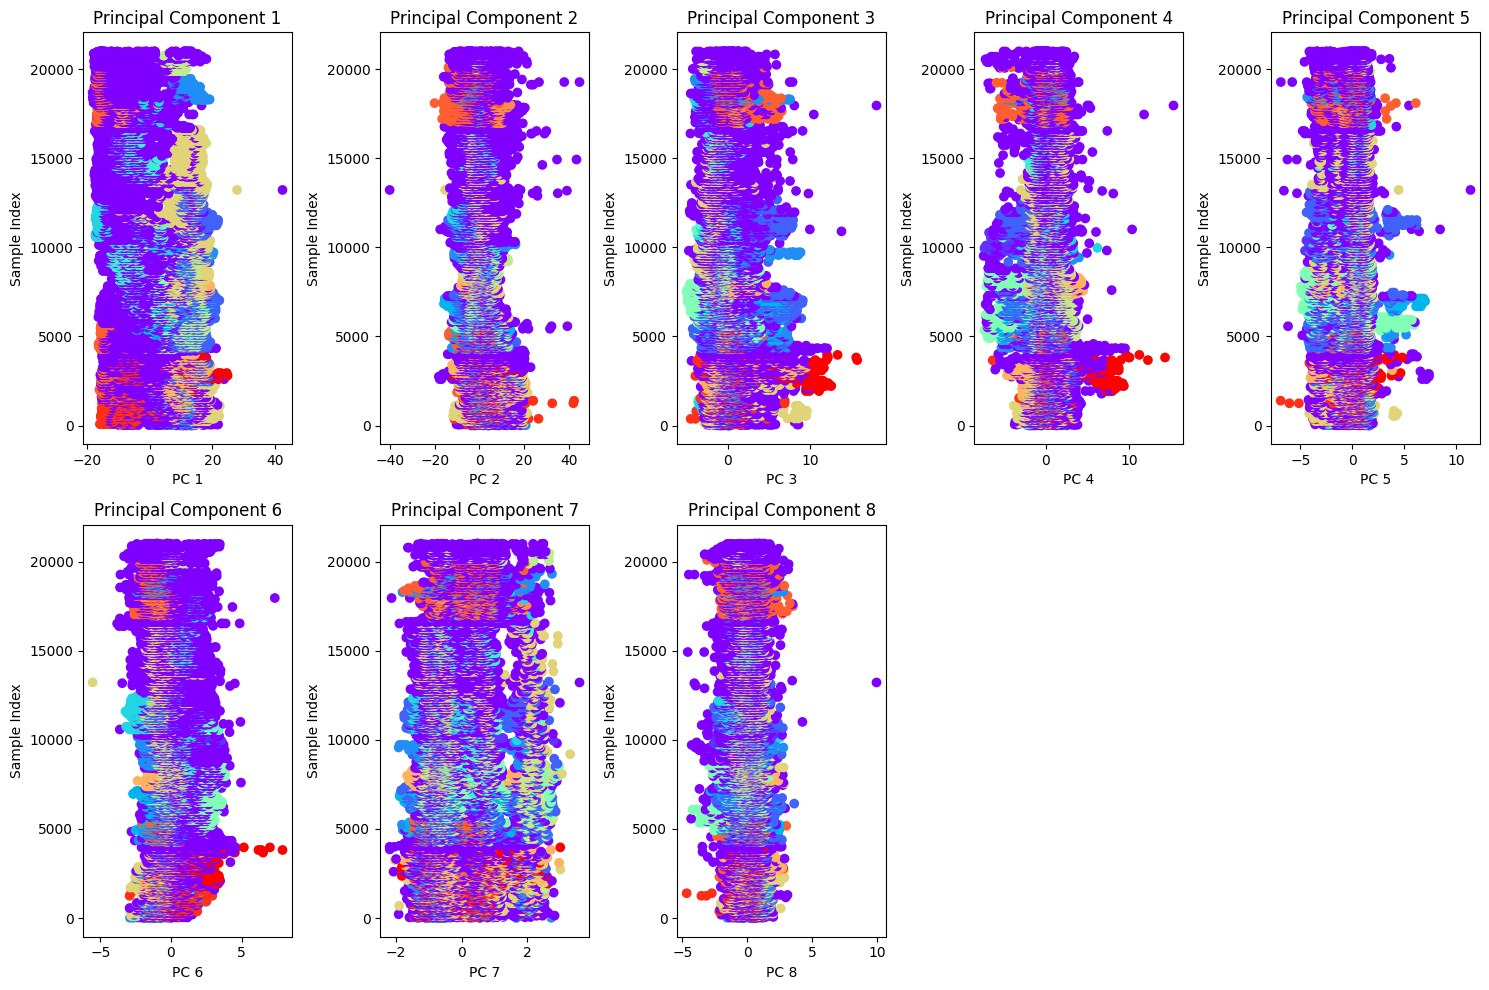

In [37]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Defined X and y  from the original dataset 

def visualize_bands(X, title='Original Images', reconstructed=False, pca=None):
    num_bands = X.shape[2]
    fig = plt.figure(figsize=(12, 6))

    if reconstructed and pca is not None:
        X_reconstructed = pca.inverse_transform(pca.transform(X.reshape((-1, num_bands)))).reshape(X.shape)
    else:
        X_reconstructed = X

    for i in range(1, 1 + 6):
        fig.add_subplot(2, 3, i)
        q = np.random.randint(num_bands)
        plt.imshow(X_reconstructed[:, :, q], cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {q}')

    plt.suptitle(title)
    plt.savefig('Original_Images.png' if not reconstructed else 'Reconstructed_Images.png')
    plt.show()

def f_PCA(X, n_components=200):
    # Reshape the data to 2D array (pixel values as features, using bands as samples)
    X_reshaped = X.reshape((-1, X.shape[2]))

    # Standardize the data
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_reshaped)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_std)

    # Print the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:", explained_variance_ratio)
    
    # Visualize the explained variance ratio
    plt.plot(np.log(explained_variance_ratio))
    plt.grid()
    plt.xlabel('Component')
    plt.ylabel('Variance Explained')
    plt.show()

    # Calculate cumulative explained variance
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Print cumulative explained variance
    print("Cumulative Explained Variance:")
    for i in range(n_components):
        print(f"PC{i + 1}: {cumulative_variance_ratio[i]}")

    # Visualize the cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative_variance_ratio, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    return X_pca, pca

# Visualize original bands
visualize_bands(X)

# Perform the PCA on 20 components, print the explained variance ratio, and visualize it 
X_pca, pca = f_PCA(X, n_components=8)

# Visualize reconstructed bands
visualize_bands(X, title='Reconstructed Images', reconstructed=True, pca=pca)

# Visualize n pcs
# flatten the X_pca matrix
n_components = 8
plt.figure(figsize=(15, 10))
for i in range(n_components):
    plt.subplot(2, 5, i + 1)
    plt.scatter(X_pca[:, i], range(len(X_pca)), c=y.flatten(), cmap='rainbow')
    plt.title(f'Principal Component {i + 1}')
    plt.xlabel(f'PC {i + 1}')
    plt.ylabel('Sample Index')

plt.tight_layout()
plt.show()


## Plot reconstructed images in different bands

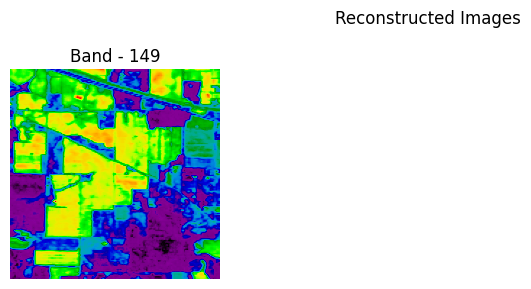

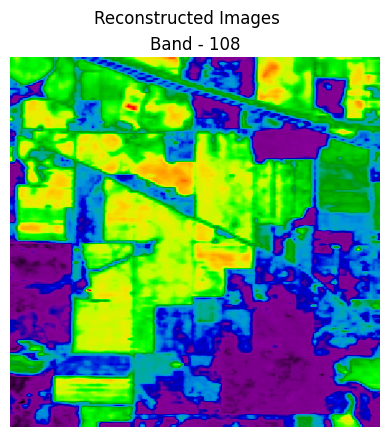

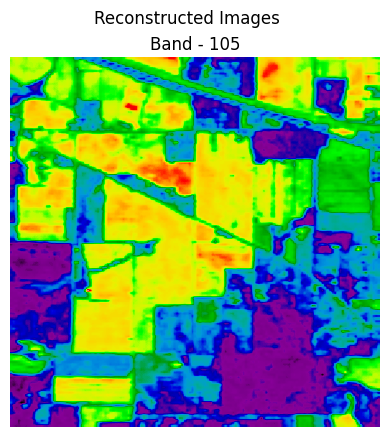

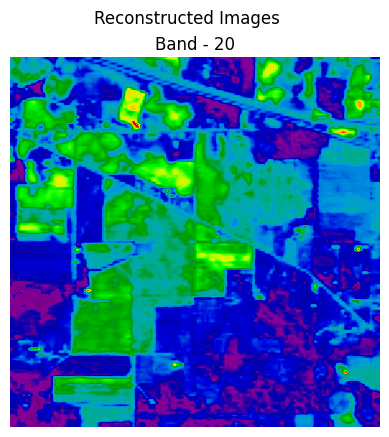

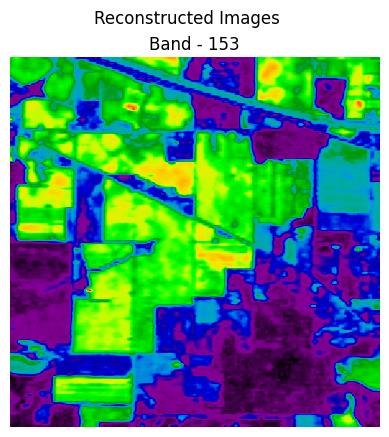

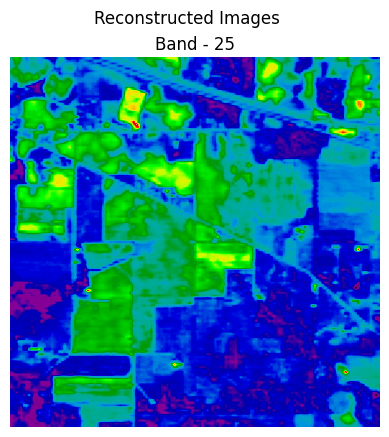

In [ ]:
#fig = plt.figure(figsize = (20, 10))
#plt.savefig('IP_PCA_Bands.png')


In [ ]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

AttributeError: 'int' object has no attribute 'to_csv'

## Classification with RF (optional: comparison with other classifiers)

In [ ]:
#Use the names below for the classes sorted


names = ['Alfalfa','Corn-notill', 'Corn-mintill','Corn','Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat','Woods','Buildings Grass Trees Drives','Stone Steel Towers']


#SPLIT DATA in TRAINING and testing

#Define classifier

#Fit and predict
#ypred = classifier.predict(X_test)

Accuracy: 61.60%

 SVM Classification Report:
                               precision    recall  f1-score   support

                     Alfalfa       0.68      0.92      0.78      3273
                 Corn-notill       1.00      0.00      0.00        16
                Corn-mintill       0.47      0.31      0.37       427
                        Corn       0.45      0.30      0.36       220
               Grass-pasture       1.00      0.00      0.00        80
                 Grass-trees       1.00      0.00      0.00       117
         Grass-pasture-mowed       1.00      0.00      0.00       227
               Hay-windrowed       1.00      0.00      0.00        11
                        Oats       0.75      0.88      0.81       146
              Soybean-notill       1.00      0.00      0.00         5
             Soybean-mintill       1.00      0.00      0.00       291
               Soybean-clean       0.44      0.76      0.55       729
                       Wheat       1.00   

/home/ed/miniconda3/envs/pipMPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2608: UserWarning: labels size, 17, does not match size of target_names, 16
  warnings.warn(
/home/ed/miniconda3/envs/pipMPI/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


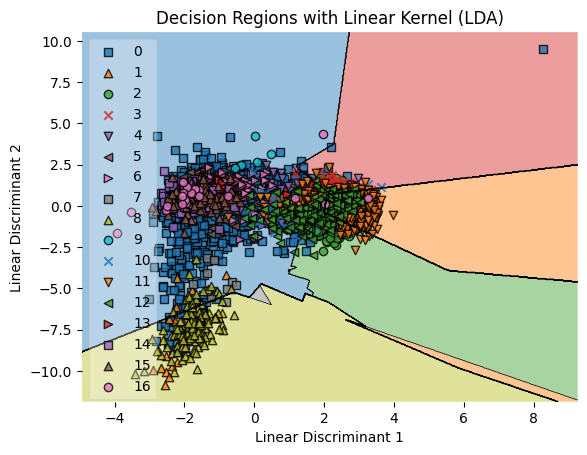

In [75]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Verify the number of unique classes and adjust class names accordingly
unique_classes_test = np.unique(y_test)
unique_classes_pred = np.unique(y_pred)

# Assuming 17 classes
class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
               'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y.flatten(), test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Initialize LDA to reduce the data to 2 components for visualization
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

# Initialize SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_lda, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_lda)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report with class names
print('\n SVM Classification Report:\n', classification_report(y_test, y_pred, labels=unique_classes_test, target_names=class_names, zero_division=1))

# Plot decision regions in the reduced 2D space
plot_decision_regions(X_test_lda, y_test, clf=svm_classifier, legend=2)
plt.title('Decision Regions with Linear Kernel (LDA)')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.show()

Accuracy: 57.45%

 SVM Classification Report:
                               precision    recall  f1-score   support

                     Alfalfa       0.66      0.92      0.77      3273
                 Corn-notill       1.00      0.00      0.00        16
                Corn-mintill       0.30      0.05      0.08       427
                        Corn       1.00      0.00      0.00       220
               Grass-pasture       1.00      0.00      0.00        80
                 Grass-trees       1.00      0.00      0.00       117
         Grass-pasture-mowed       1.00      0.00      0.00       227
               Hay-windrowed       1.00      0.00      0.00        11
                        Oats       1.00      0.00      0.00       146
              Soybean-notill       1.00      0.00      0.00         5
             Soybean-mintill       1.00      0.00      0.00       291
               Soybean-clean       0.35      0.82      0.49       729
                       Wheat       1.00   

/home/ed/miniconda3/envs/pipMPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2608: UserWarning: labels size, 17, does not match size of target_names, 16
  warnings.warn(
/home/ed/miniconda3/envs/pipMPI/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


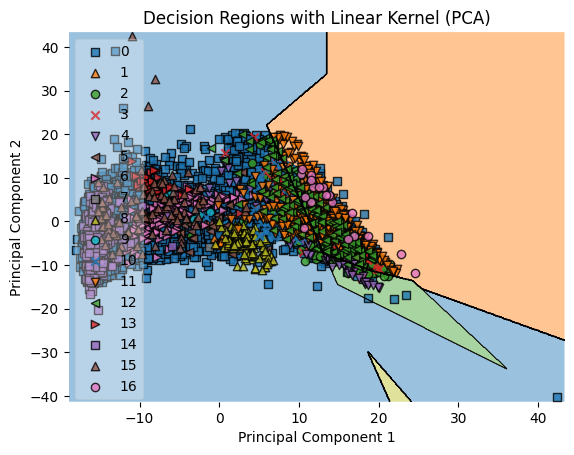

In [77]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt

# Verify the number of unique classes and adjust class names accordingly
unique_classes_test = np.unique(y_test)
unique_classes_pred = np.unique(y_pred)

# Assuming 17 classes
class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
               'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y.flatten(), test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Initialize PCA to reduce the data to 42 components
pca = PCA(n_components=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Use only the first two principal components for visualization
X_train_pca_2d = X_train_pca[:, :2]
X_test_pca_2d = X_test_pca[:, :2]

# Initialize SVM classifier with a linear kernel
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_pca_2d, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_pca_2d)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report with class names
print('\n SVM Classification Report:\n', classification_report(y_test, y_pred, labels=unique_classes_test, target_names=class_names, zero_division=1))

# Plot decision regions in the reduced 2D space
plot_decision_regions(X_test_pca_2d, y_test, clf=svm_classifier, legend=2)
plt.title('Decision Regions with Linear Kernel (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Accuracy: 51.89%

SVM Classification Report:
                               precision    recall  f1-score   support

                     Alfalfa       0.52      1.00      0.68      3273
                 Corn-notill       1.00      0.00      0.00        16
                Corn-mintill       1.00      0.00      0.00       427
                        Corn       1.00      0.00      0.00       220
               Grass-pasture       1.00      0.00      0.00        80
                 Grass-trees       1.00      0.00      0.00       117
         Grass-pasture-mowed       1.00      0.00      0.00       227
               Hay-windrowed       1.00      0.00      0.00        11
                        Oats       1.00      0.00      0.00       146
              Soybean-notill       1.00      0.00      0.00         5
             Soybean-mintill       1.00      0.00      0.00       291
               Soybean-clean       1.00      0.00      0.00       729
                       Wheat       1.00    

/home/ed/miniconda3/envs/pipMPI/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2608: UserWarning: labels size, 17, does not match size of target_names, 16
  warnings.warn(


KeyboardInterrupt: 

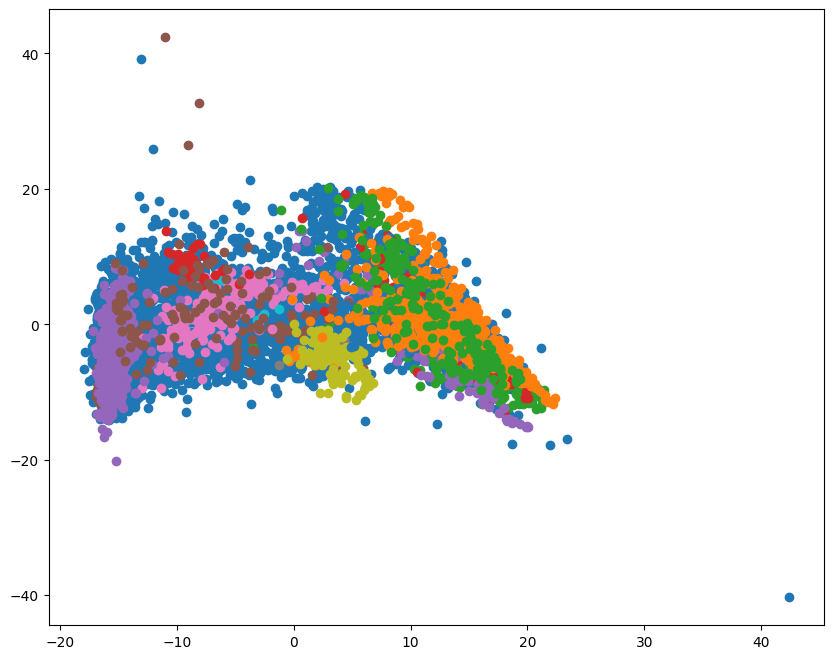

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'X' and 'y' are defined or imported

# Verify the number of unique classes and adjust class names accordingly
unique_classes_test = np.unique(y_test)

# Assuming 17 classes
class_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
               'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings Grass Trees Drives', 'Stone Steel Towers']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y.flatten(), test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Initialize PCA to reduce the data to 42 components
pca = PCA(n_components=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Use only the first two principal components for visualization
X_train_pca_2d = X_train_pca[:, :2]
X_test_pca_2d = X_test_pca[:, :2]

# Initialize SVM classifier with a polynomial kernel
svm_classifier = SVC(kernel='poly', degree=2, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_pca_2d, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_pca_2d)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Display classification report with class names
print('\nSVM Classification Report:\n', classification_report(y_test, y_pred, labels=unique_classes_test, target_names=class_names, zero_division=1))

# Visualize decision regions
plt.figure(figsize=(10, 8))

# Plot each class
for i, class_name in enumerate(class_names):
    indices = y_test == i
    plt.scatter(X_test_pca_2d[indices, 0], X_test_pca_2d[indices, 1], label=class_name)

# Plot decision regions
h = .02  # Step size in the mesh
x_min, x_max = X_test_pca_2d[:, 0].min() - 1, X_test_pca_2d[:, 0].max() + 1
y_min, y_max = X_test_pca_2d[:, 1].min() - 1, X_test_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)

# Set labels and legend
plt.title('Decision Regions with Polynomial Kernel (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='upper right')

# Show the plot
plt.show()


In [ ]:
#PLOT THE CONFUSION MATRIX Associate to the classifier

#data = confusion_matrix(y_test, ypred)
#df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
#plt.savefig('cmap.png', dpi=300)

In [ ]:
#print(classification_report(y_test, ypred, target_names = names))

## Classification Map

In [ ]:
#Use the function below to produce the classification map


def reconstruct_classification_map(q, classifier):
    l=[]
    for i in range(q.shape[0]):
      if q.iloc[i, -1] == 0:
        l.append(0)
      else:
        l.append(classifier.predict(q.iloc[i, :-1].values.reshape(1, -1)))
    return l


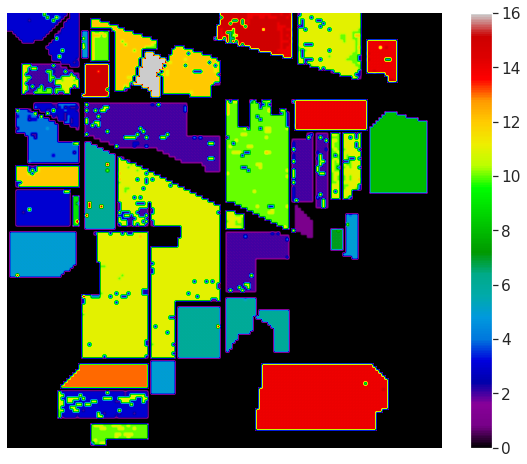

In [ ]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()



---



---

